# Static Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, ker_BaO, 
                               slice_dim, ylabel, initialize_data_dr_sim):
        trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
        
        return x_BaO, y_BaO, trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
print('Sum preStim gamma are: \n', X0_psd, '\n','freq and amplitude used are: \n', U1[0:4])

Sum preStim gamma are: 
      sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [7]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [8]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [9]:
n_burn_in = 20
n_samples= 150
n_acquisition = 50

## 1.2 First BaO Model is trained on all of the dataset

In [10]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [11]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e388e0c430>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e388e0c3d0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0002   2.968181e+03   2.492593e+05 
    00s16  0003   2.244134e+03   6.415869e+04 
    01s25  0034   1.115247e+03   6.434336e-10 
Runtime:     01s25
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3896d1c40>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3896cb760>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e389724160>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3897246a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3897246d0>]}

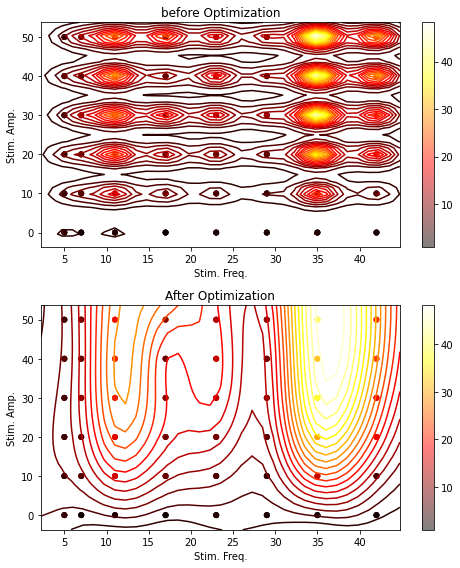

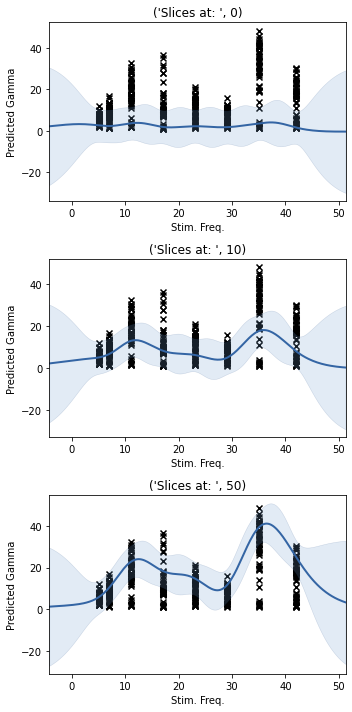

In [12]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

## 1.3: Train the second model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp/PreStimGamma 

- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [13]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))

Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [

In [14]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

#### 1.3.1: initial training

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e389eb8dc0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e389ea2d30>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   7.051366e+01   7.256383e-03 
    00s06  0013   7.000382e+01   9.583734e-04 
    00s11  0020   6.950593e+01   4.687393e-03 
    00s15  0026   6.946115e+01   3.048990e-05 
    00s17  0030   6.946105e+01   5.485899e-12 
Runtime:     00s17
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3878d9250>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3878b4d30>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e387a1a970>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e387a1aeb0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e387a29040>]}

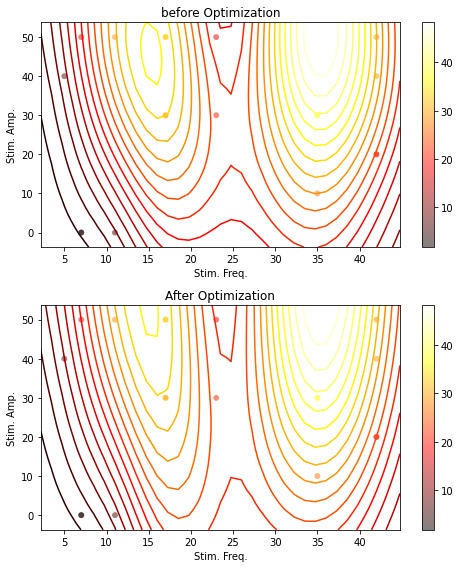

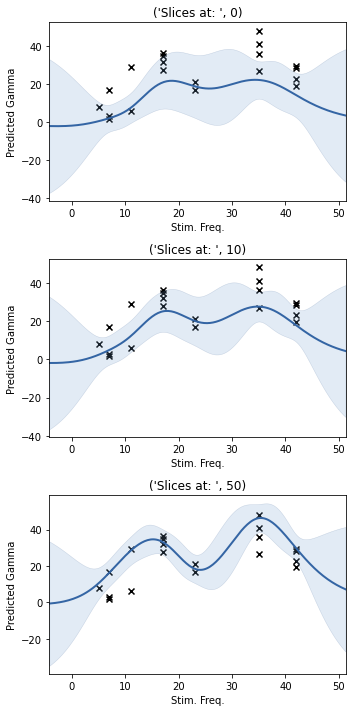

In [15]:
x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO, slice_dim, ylabel)

#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [16]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  3  3  4  4  5  5  5  5  6  6  7  7  8  8  8  9  9  9  9 10 10 11 11
 11 11 11 11 12 12 12 12 12 13 14 14 15 15 15 16 16 16 16 17 17 17 17 18
 18 18 18 18 19 19 19 19 19 19 19 20 20 20 20 21 22 22 22 23 23 23 23 24
 24 24 24 24 26 26 27 27 27 28 28 29 29 29 29 29 29 30 30 30 30 31 31 31
 32 32 33 34 34 34 34 34 34 34 35 35 36 36 36 36 36 37 37 37 37 37 38 39
 39 39 39 40 40 40 40 40 40 40 40 40 40 40 40 41 41 41 41 41 41 41 42 42
 42 42 42 42 42 42]
[ 1  1  1  2  3  3  4  4  4  5  5  7  7  7  8  8  8  9  9 10 10 10 11 11
 11 11 12 12 12 12 12 12 13 13 13 13 13 14 14 15 15 16 16 16 18 19 19 20
 20 20 20 22 22 22 23 23 25 25 25 25 25 25 26 26 27 27 28 28 28 29 29 30
 30 30 31 31 31 31 32 33 34 34 35 35 35 35 35 35 35 35 36 37 37 37 37 37
 38 38 38 38 38 38 38 39 39 39 39 39 39 40 40 40 41 41 41 41 41 41 41 42
 42 42 42 42 43 44 44 44 44 45 46 46 46 47 47 47 48 48 48 48 48 49 49 49
 49 49 49 50 50 50] (150,)


In [18]:
# sample mean preStimGamma: for the Static BaO we just use the mean preStim Gamma
mean_preStimGamma = np.empty((n_samples,))
mean_preStimGamma[:] = np.mean(X0_psd, axis=0)
print(mean_preStimGamma[0], np.shape(mean_preStimGamma))

2.171337907722562 (150,)


In [19]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, mean_preStimGamma])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(np.shape(testX))

(150,) (150,)
(3, 150)
(150, 3)


In [20]:
simY_BaO_AF = np.empty((1, n_samples))
simMse_BaO_AF = np.empty((1, n_samples))

simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);

print("mean is: \n",simY_BaO_AF[0:3,0:3],"\n\n Variance is: \n", simMse_BaO_AF[0:3,0:3])
# posteriorTestY
print(np.shape(state_est_BaO_AF),'\n',state_est_BaO_AF[:,0:10])
print(np.shape(simY_BaO_AF),'\n', np.shape(simMse_BaO_AF))

mean is: 
 [[-1.52078077]
 [-0.63195552]
 [-0.63195552]] 

 Variance is: 
 [[130.04288146]
 [ 66.049609  ]
 [ 66.049609  ]]
(1, 150) 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(150, 1) 
 (150, 1)


In [21]:
# inspecting the inputs to acquistion_function:
print(np.shape(testX_BaO))
print(testX_BaO[:,0:3])

# Mean and variance after initial training using "burn-in" points:
print("mean is: \n",simY_BaO_AF[0, 0],"\n\n Variance is: \n", simMse_BaO_AF[0, 0])

nu = 0.1
print("nu set at: ", nu)
# t = the sample we are on 

(3, 150)
[[1.         3.         3.        ]
 [1.         1.         1.        ]
 [2.17133791 2.17133791 2.17133791]]
mean is: 
 -1.5207807709399301 

 Variance is: 
 130.0428814611011
nu set at:  0.1


In [22]:
ucb = np.empty((1, n_samples))
print(np.shape(ucb))

(1, 150)


In [23]:
ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
print(np.shape(ucb))
max_ucb = np.max(ucb, axis=0)
print(np.shape(max_ucb))
print(max_ucb)

argMax_ucb = ucb.argmax()
print(argMax_ucb)

# find the values of argMax_ucb in the sample grid
ucb_sample = testX[argMax_ucb]
print(ucb_sample, np.shape(ucb_sample))
ucb_sample = np.reshape(ucb_sample, (1,3))
print(np.shape(ucb_sample))

(150, 1)
(1,)
[50.70520928]
93
[31.         37.          2.17133791] (3,)
(1, 3)


In [24]:
# Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model

state_est_BaO = trained_model_BaO.posterior_samples(ucb_sample, full_cov=True, size=1)[:,0,0]
simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample);
print("state_est_BaO: \n", state_est_BaO)
print("mean is: \n",simY_BaO,"\n\n Variance is: \n", simMse_BaO)

state_est_BaO: 
 [28.03749073]
mean is: 
 [[37.1825222]] 

 Variance is: 
 [[-565.82160967]]


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.


In [25]:
# append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points

next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[0,0])], 'Stim_2':[int(ucb_sample[0,1])]})
print(next_sample_to_optimize, np.shape(next_sample_to_optimize))
# print(len(U1_init.index))

U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
print(U1_init)

   Stim_1  Stim_2
0      31      37 (1, 2)
    Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      31      37


In [26]:
# sum_preStim_gamma
next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[mean_preStimGamma[0]]})
print(next_preStimGamma)
X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)

print(X0_psd_init)

   sum_preStim_gamma
0           2.171338
    sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816
20           2.171338


In [27]:
# Concatenate the first model predicted postStimGamma 

print(X1_init, np.shape(X1_init))
next_postStimGamma = np.empty((1,1))
next_postStimGamma[0,:] = [state_est_BaO]
print(next_postStimGamma,np.shape(next_postStimGamma))
X1_init = np.append(X1_init, next_postStimGamma, axis=0)
print(X1_init, np.shape(X1_init))

[[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]] (20, 1)
[[28.03749073]] (1, 1)
[[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]
 [28.54172459]
 [48.27246273]
 [ 6.00115734]
 [ 2.96172226]
 [27.66113194]
 [29.12656713]
 [34.90446486]
 [40.92827493]
 [ 8.02083908]
 [22.91482488]
 [21.03253269]
 [16.68539907]
 [26.89885834]
 [31.85413914]
 [ 1.7873916 ]
 [19.26713018]
 [28.03749073]] (21, 1)


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e388cf2a00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e388cdc670>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0004   7.581397e+01   4.483726e+00 
    00s14  0009   7.273006e+01   2.326922e-03 
    00s17  0011   7.271476e+01   1.285174e-03 
    00s30  0021   7.270934e+01   2.599988e-09 
Runtime:     00s30
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e388cf2d90>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e389f48e20>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e387aee490>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e387abbd30>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e387abbc40>]}

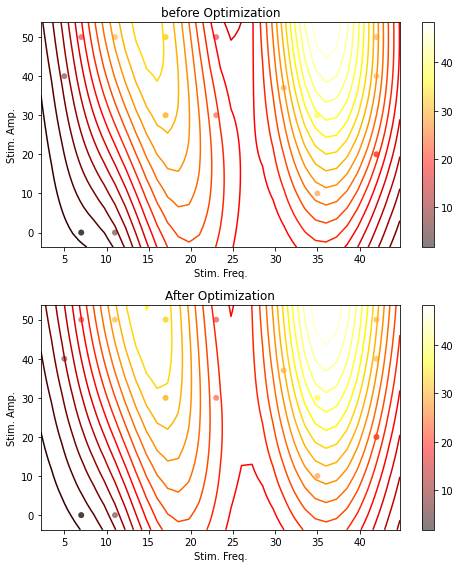

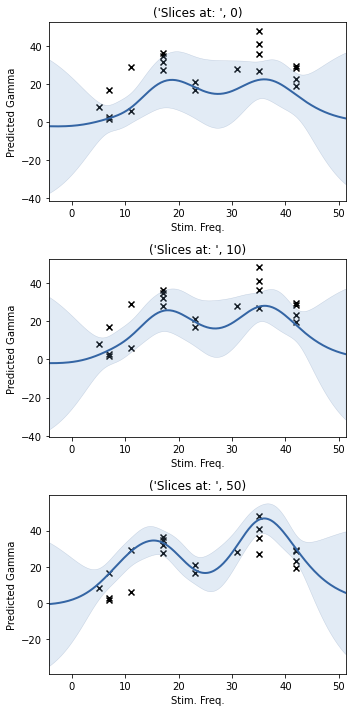

In [28]:
x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO, slice_dim, ylabel)

(1, 150)
nu set at:  0.1


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38d83edc0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38df1cd30>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   1.162577e+02   4.450617e+02 
    00s09  0009   8.119038e+01   7.649797e-03 
    00s16  0017   8.108364e+01   4.948242e-03 
    00s31  0037   8.097763e+01   1.493801e-10 
Runtime:     00s31
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38de4ee20>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38de4e340>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e058af0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e38e064070>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38e0640a0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e089fa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e077cd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0004   8.938636e+01   4.685842e+00 
    00s17  0014   8.593248e+01   3.451671e-06 
    00s33  0032   8.589870e+01   1.249553e-10 
Runtime:     00s33
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e137640>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e11c130>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e27d7c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e38e27dd00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38e27dd30>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e2c3880>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e2a95e0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   2.081859e+02   3.006136e+03 
    00s17  0008   1.000727e+02   2.330794e-01 
    00s55  0039   9.782134e+01   3.887029e-11 
Runtime:     00s55
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e380f70>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e36cdf0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e4da370>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e38e4da8b0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38e4da8e0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e5223a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e505340>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0009   1.125020e+02   8.092992e-03 
    00s16  0010   1.124729e+02   1.353490e-03 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0011   1.124625e+02   7.075111e-04 
    00s48  0042   1.088718e+02   1.653920e-10 
Runtime:     00s48
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e5eb4f0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e5db3d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e72eb80>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e38e72efa0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38e73f130>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e776af0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e6e0940>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   1.467571e+02   2.966136e+02 
    00s04  0003   1.310409e+02   1.664690e+01 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s11  0007   1.256129e+02   1.530252e+00 
    00s19  0012   1.250822e+02   9.754712e-06 
    01s00  0103   1.222500e+02   2.757263e-06 
Runtime:     01s00
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38e83df40>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38e827dc0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38f919c40>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e38f92a1c0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38f92a1f0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38f961ee0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38f948c40>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0005   1.297099e+02   1.111875e+00 
    00s08  0006   1.288738e+02   2.944751e-01 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s12  0008   1.282034e+02   1.553571e-02 
    00s19  0012   1.282431e+02   1.483014e-03 
    00s78  0077   1.281110e+02   1.402313e-03 
Runtime:     00s78
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38f9e9be0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38f9d3820>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38faf8760>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e38faf8ca0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38faf8cd0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38fb3e9d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38fb26610>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.530881e+02           nan 
    00s06  0004   1.366388e+02   3.765555e+00 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s08  0005   1.352348e+02   1.068462e+00 
    00s17  0011   1.336039e+02   9.834551e-06 
    00s66  0058   1.334328e+02   3.622165e-06 
Runtime:     00s66
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38fbcc5b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38fba9970>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38dccba60>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3871f5850>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38a03ee20>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38fc7f5b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38fc74250>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.796844e+02           nan 
    00s08  0008   1.393574e+02   5.345230e-03 
    00s10  0010   1.393212e+02   5.268520e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s14  0014   1.393217e+02   1.711029e-07 
    00s19  0018   1.393212e+02   1.759478e-07 
    00s45  0053   1.393212e+02   1.756198e-07 
Runtime:     00s45
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38fd19640>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38fcff280>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38fe26280>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e38fe26880>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e38fe268b0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38fe6d460>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38fe4f0a0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0002   1.507612e+02   1.907320e+01 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s08  0003   1.502852e+02   1.473628e+01 
    00s19  0008   1.460912e+02   8.578011e-03 
    01s08  0082   1.460474e+02   3.402057e-07 
Runtime:     01s08
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38feebe80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38fed39a0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e38fff6ee0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e390006460>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e390006490>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39003ddf0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390027910>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   1.522307e+02   2.838900e-01 
    00s07  0010   1.516872e+02   1.875699e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s11  0012   1.516872e+02   1.902696e-06 
    00s19  0017   1.516872e+02   2.563613e-06 
    01s08  0093   1.516872e+02   8.515171e-07 
Runtime:     01s08
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3900c79d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3900b03d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3901c56a0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3901d4c40>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3901d4c70>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:46: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39021c8e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3902062b0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0005   1.570654e+02   1.033867e-07 
    00s17  0012   1.570653e+02   5.213383e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0013   1.571794e+02   2.798856e-04 
    00s56  0054   1.570652e+02   1.373713e-07 
Runtime:     00s56
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3902ab280>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390287880>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3903b5250>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3903b5670>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3903b56a0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3903f2f40>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3903dbd30>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   1.625029e+02   5.975431e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s11  0006   1.625089e+02   5.100130e-04 
    00s18  0012   1.625093e+02   5.718265e-04 
    00s27  0022   1.625028e+02   5.975431e-04 
Runtime:     00s27
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39047d910>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3904659d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390589a60>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e390589fa0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e390589940>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3905cea90>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3905b5a30>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0006   1.715979e+02   5.264876e-04 
    00s08  0007   1.715919e+02   6.160106e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s15  0020   1.715919e+02   6.151659e-04 
    00s35  0030   1.715919e+02   6.151571e-04 
Runtime:     00s35
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3906578e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390640730>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390761a60>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e390761fa0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e390771130>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3907ac8b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390794610>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0002   1.806897e+02   9.214962e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s10  0006   1.806858e+02   6.508527e-04 
    00s18  0011   1.806791e+02   6.436376e-04 
    00s25  0022   1.806791e+02   6.436376e-04 
Runtime:     00s25
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39083b2b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39081e0a0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39093afa0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e39094b520>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e39094b550>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390981fa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39096ad90>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   1.865203e+02   9.219845e-04 
    00s06  0005   1.865163e+02   6.445382e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s10  0008   1.865096e+02   6.432497e-04 
    00s22  0022   1.865096e+02   6.432497e-04 
Runtime:     00s22
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390a0ce50>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3909f6a60>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390b169d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e390b16f10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e390b270a0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390b5ec70>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390b488b0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0005   1.924705e+02   6.451566e-04 
    00s07  0006   1.924705e+02   6.511087e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0014   1.924638e+02   6.438923e-04 
    00s22  0022   1.924638e+02   6.438923e-04 
Runtime:     00s22
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390be8940>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390bd97f0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390cdcd30>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e390cf4d00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e390cf4d30>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390d1cf40>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e38fe09070>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0007   1.978522e+02   6.431479e-04 
    00s12  0010   1.978455e+02   6.397627e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0016   1.978455e+02   6.397627e-04 
Runtime:     00s18
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390d83a00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390d7a610>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390e97880>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e390e97dc0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e390e97df0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390ed05e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390ec75e0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0006   2.036283e+02   6.461159e-04 
    00s09  0008   2.036216e+02   6.389259e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0018   2.036216e+02   6.389259e-04 
Runtime:     00s18
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e390f61340>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e390f4cfa0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39107a1c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e39107a700>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e39107a730>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3910c3310>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3910a6070>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.092246e+02           nan 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s11  0005   2.092313e+02   6.381877e-04 
    00s23  0013   2.092246e+02   6.366562e-04 
Runtime:     00s23
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39113fdf0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e391128910>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39124ad60>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e39125b3d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e39125b520>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e391293b50>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39127ac10>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0005   2.147112e+02   6.350267e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s08  0006   2.147112e+02   6.405391e-04 
    00s19  0014   2.147045e+02   6.333788e-04 
    00s27  0022   2.147045e+02   6.333788e-04 
Runtime:     00s27
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3922ef6a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3922d70d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3923e9550>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3923faaf0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3923fab20>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3924435b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392428310>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0004   2.206148e+02   4.842059e-04 
    00s09  0006   2.206161e+02   6.407684e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0013   2.206093e+02   6.336070e-04 
    00s33  0022   2.206093e+02   6.336070e-04 
Runtime:     00s33
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3924c3fa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3924a27f0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3925cff40>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3925dc4f0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3925dc520>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392615fa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3925fe7f0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0004   2.274874e+02   4.880309e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s10  0005   2.274886e+02   6.431913e-04 
    00s23  0016   2.274820e+02   6.418502e-04 
Runtime:     00s23
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3926a09d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39268b970>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3927abbb0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3927b9130>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3927aba90>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3927f3a90>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3927dbb50>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0009   2.330105e+02   6.460915e-04 
    00s22  0016   2.330038e+02   6.388985e-04 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392864460>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3928643d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39298b6d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e39298bc10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e39298bc40>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3929d0580>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3929b86d0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   4.225758e+02           nan 
    00s12  0005   4.222314e+02   6.858879e-03 
    00s15  0009   3.167703e+02   3.530042e-06 
    00s18  0011   3.088226e+02   2.834507e-06 
    02s36  0140   2.769242e+02   1.798181e-08 
Runtime:     02s36
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392a5e160>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392a420a0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392b5eee0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e392b6e460>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e392b6e490>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392ba6fa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392b8eeb0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   2.843197e+02   1.800814e-08 
    00s09  0008   2.843197e+02   1.868205e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s14  0010   2.843197e+02   1.863467e-08 
Runtime:     00s14
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392c2fd00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392c2ffd0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392d3a9d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e392d3af10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e392d4b0a0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392d75c10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392d6c850>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.910638e+02           nan 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s14  0004   2.910638e+02   2.728648e-08 
    00s19  0006   2.910638e+02   2.044621e-08 
    00s49  0029   2.910638e+02   1.787009e-08 
Runtime:     00s49
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392e123d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392dedfd0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392f1a7c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e392f1ad00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e392f1ad30>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392f62ac0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392f4b670>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0003   2.978941e+02   2.819836e-08 
    00s06  0004   2.978941e+02   1.802922e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s09  0007   2.978941e+02   1.777069e-08 
Runtime:     00s09
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e392ff32b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e392fcedc0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3930f0f10>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e393102580>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e393102700>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3931461c0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393121ca0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0005   3.045900e+02   1.810975e-08 
    00s13  0008   3.045900e+02   1.772353e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s22  0012   3.045900e+02   1.772353e-08 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3931c3b20>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3931ac160>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39329bb20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3932a70a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3932a70d0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3932daeb0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3932cdd30>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0009   3.112157e+02   1.763023e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s09
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393367760>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39334e280>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3934717c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e393471d00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e393471d30>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3934b7a00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3934a0520>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   3.178407e+02   5.820950e-08 
    00s09  0008   3.178406e+02   1.765685e-08 
    00s10  0009   3.178406e+02   1.764530e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s11  0011   3.178406e+02   1.764351e-08 
Runtime:     00s11
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393547310>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393523c40>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393645100>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3936516d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e393651700>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393697520>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393675ee0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   3.263958e+02           nan 
    00s09  0008   3.263958e+02   1.792402e-08 
    00s12  0012   3.263958e+02   1.785163e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s12
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393718b80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3936f0be0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393821df0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e393832250>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e393832280>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39386ae80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39384a580>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0003   3.333896e+02   1.792035e-08 
    00s08  0006   3.333896e+02   2.084949e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s10  0008   3.333896e+02   2.054201e-08 
Runtime:     00s10
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3938f6640>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3938de580>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393a01790>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e393a01cd0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e393a01d00>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393a48820>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393a2e730>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0004   9.886684e+02   2.815748e+01 
    00s07  0008   5.876055e+02   5.336316e-01 
    00s10  0011   4.559885e+02   1.806161e-02 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s16  0017   3.821730e+02   1.688127e-05 
    00s33  0031   3.748569e+02   1.886492e-11 
Runtime:     00s33
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393ab10a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393aba040>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393be1400>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e393be1940>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e393be1970>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393c245e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393c0b3d0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   3.842336e+02   1.323768e-06 
    00s06  0006   3.838349e+02   1.225980e-06 
    00s11  0011   3.817772e+02   2.704748e-11 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s12  0012   3.817772e+02   2.704748e-11 
Runtime:     00s12
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e393c97b80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393c8f700>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e394d73970>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e394d910d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e394d91100>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e394db9d60>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e394db28b0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0004   3.921729e+02   5.728688e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s13  0008   3.904112e+02   8.431629e-10 
    00s20  0014   3.903671e+02   6.203831e-11    00s19  0013   3.903671e+02   6.203831e-11  
Runtime:     00s20
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e394e56880>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e394e3d5b0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e394f625e0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e394f62b20>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e394f62b50>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e394faa850>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e394f92490>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   3.989003e+02   9.326669e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s17  0007   3.985060e+02   5.525101e-08 
    00s24  0011   3.980348e+02   9.168715e-11 
Runtime:     00s24
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39502ef10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395015a60>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395137e20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3951463a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3951463d0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39518d130>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395166c10>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0002   4.085546e+02   1.129699e-07 
    00s10  0004   4.085472e+02   1.438340e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s29  0014   4.071466e+02   2.099643e-11 
Runtime:     00s29
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39520ba30>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3951e27f0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395306940>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e395315ee0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e395324070>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39535ed00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395346700>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   4.149841e+02   2.155499e-08 
    00s04  0002   4.149839e+02   2.382752e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s11  0006   4.149283e+02   2.604465e-08 
    00s18  0010   4.144941e+02   9.967218e-11 
Runtime:     00s18
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3953cafa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3953c2a60>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3954f54f0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3954f5910>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3954f5940>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39553d610>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395511c70>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   4.211029e+02   2.396934e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s04  0002   4.211029e+02   2.660341e-09 
    00s17  0010   4.210184e+02   8.955389e-11 
Runtime:     00s17
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3955a32b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3955bcfd0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3956b1a60>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3956d7280>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3956d72b0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395711d30>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3956f8cd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   4.279894e+02           nan 
    00s02  0001   4.279894e+02   7.075033e-10 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s14  0007   4.279634e+02   1.338091e-10 
    00s15  0008   4.279634e+02   1.338091e-10 
Runtime:     00s15
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39579e5b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395784430>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3958a59d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3958a5f10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3958b20a0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3958ebd30>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3958d6a90>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0002   4.344825e+02   5.976782e-11 
Runtime:     00s05
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3959710d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39595be50>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395a7af70>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e395a8c580>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e395a8c5b0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395ac5250>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395aaed60>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   4.411371e+02   9.531402e-11 
Runtime:     00s01
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395b53b80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395b387c0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395c5bbb0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e395c6b130>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e395c6b160>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395c95e20>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395c8aa60>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   4.482184e+02   6.597362e-11 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s02
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395cc32b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e393bee1f0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395de68e0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e395de6e20>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e395de6e50>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395e1faf0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395e18640>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   4.553570e+02   1.645237e-10 
Runtime:     00s01
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395eba550>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395e9f100>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395fc73d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e395fc7910>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e395fc7940>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e395ffe610>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e395ff3250>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0007   4.617554e+02   8.729690e-11 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s06
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39608ef70>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e396077af0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e396199e20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3961a83a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3961a83d0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3961ee1f0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3961cacd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0005   4.725468e+02   1.402808e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s14  0010   4.722397e+02   3.216296e-10 
    00s19  0013   4.721101e+02   3.179690e-11 
    00s19  0014   4.721101e+02   3.179690e-11 
Runtime:     00s19
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39626b8b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3962563d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3963777c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e396377d00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e396377d30>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3963bfa00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3963a7520>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0007   4.787063e+02   1.884238e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s10  0008   4.786753e+02   5.574469e-10 
    00s12  0010   4.786571e+02   8.012448e-12 
Runtime:     00s12
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e396450220>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39642a880>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39655a220>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e39655a640>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e39655a670>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\core\gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3965a13d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39657b8b0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0002   5.946617e+02   6.097573e-06 
    00s17  0009   5.374513e+02   4.479898e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s23  0014   5.318520e+02   1.702593e-10 
Runtime:     00s23
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e39661fbb0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e396605b50>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3976e4850>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e397708130>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3976e48b0>]}

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:No contour levels were found within the data range.
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e397741be0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e39772ab80>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0003   5.452001e+02   4.743390e-08 
    00s11  0009   5.418041e+02   1.191998e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s15  0012   5.394202e+02   2.254330e-10 
Runtime:     00s15
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3977cb820>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1e3977b3580>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1e3978d6820>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1e3978d6d60>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1e3978d6d90>]}

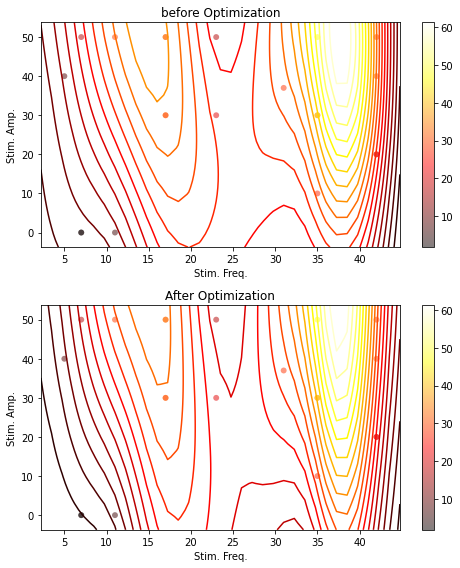

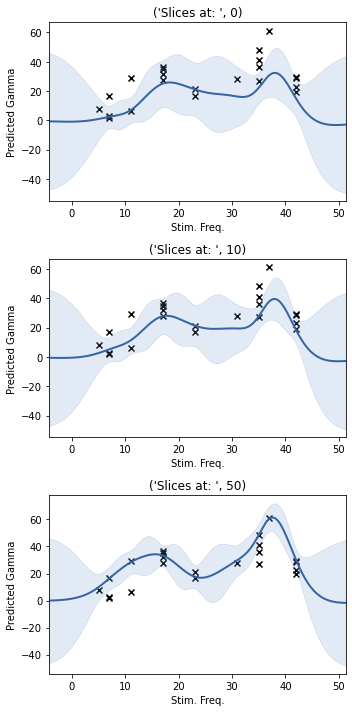

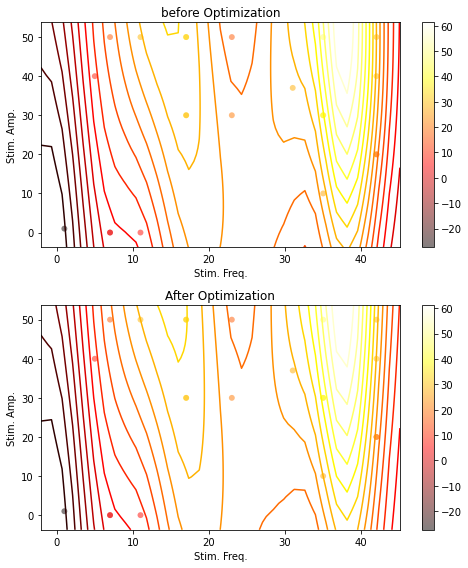

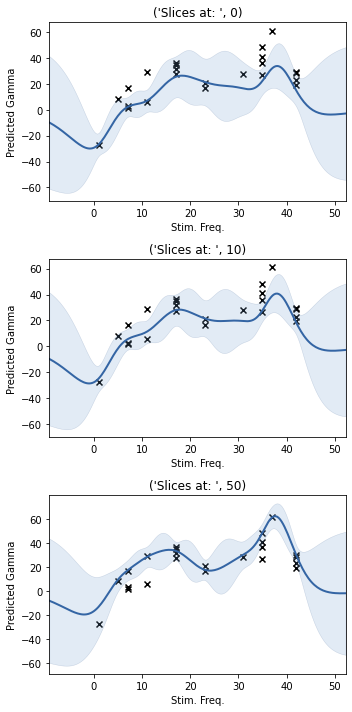

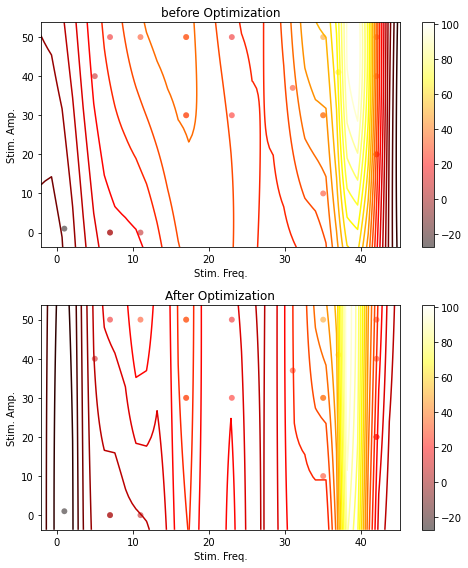

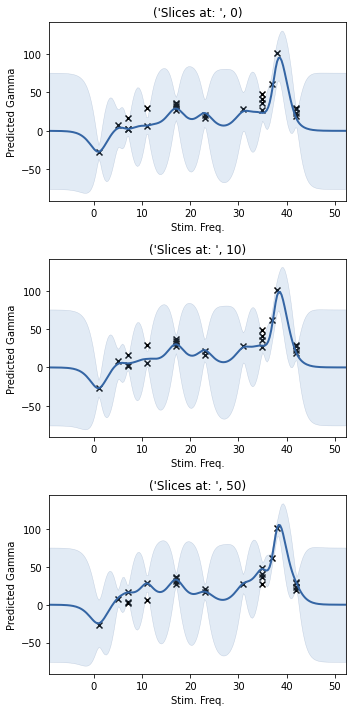

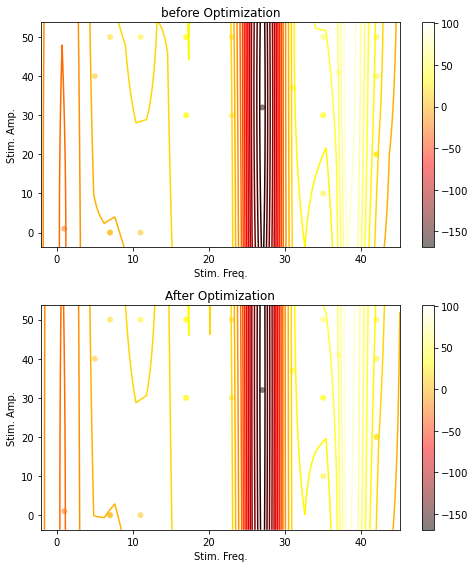

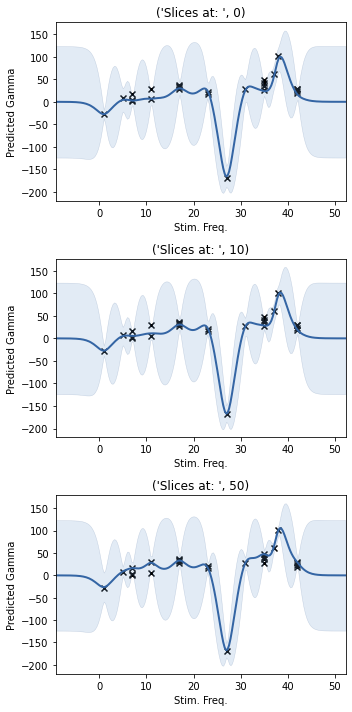

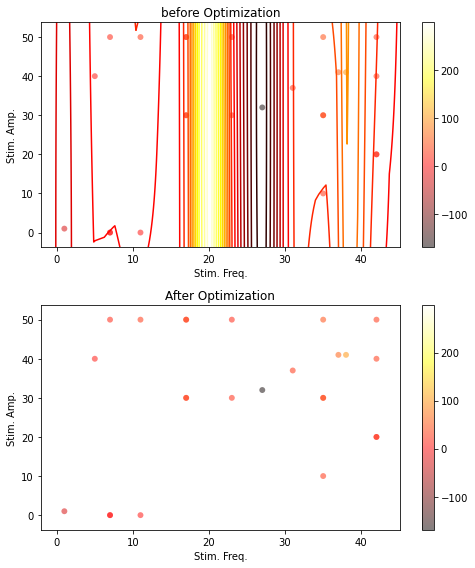

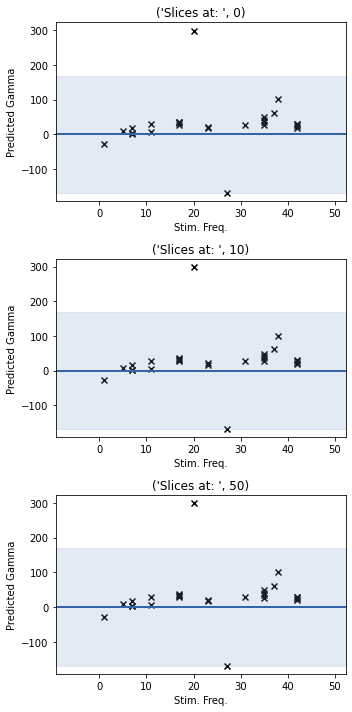

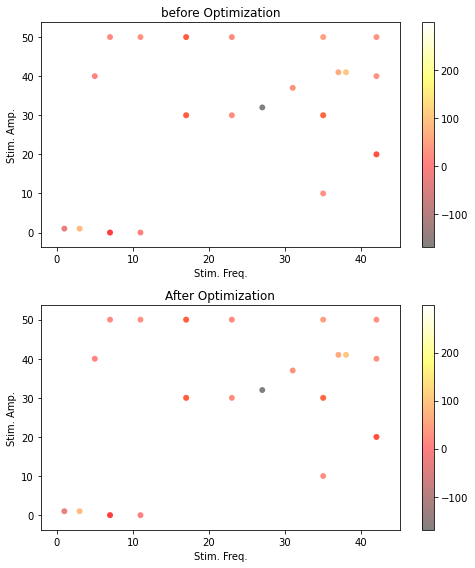

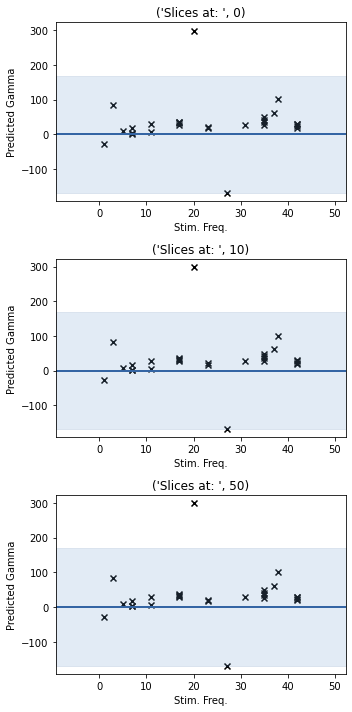

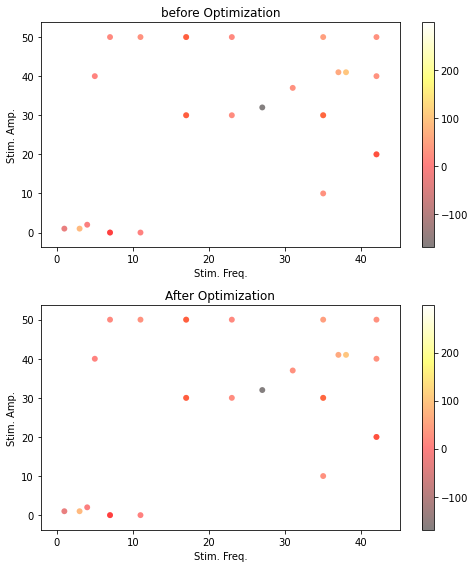

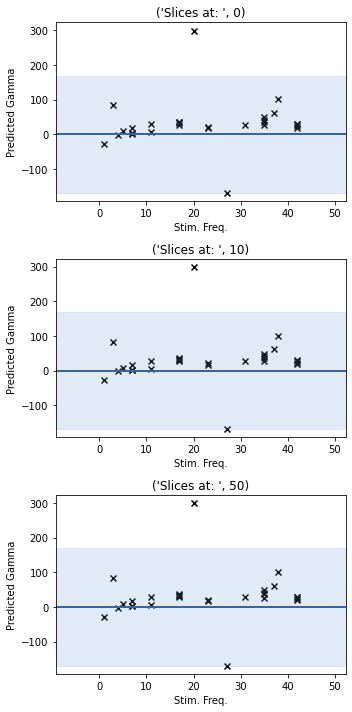

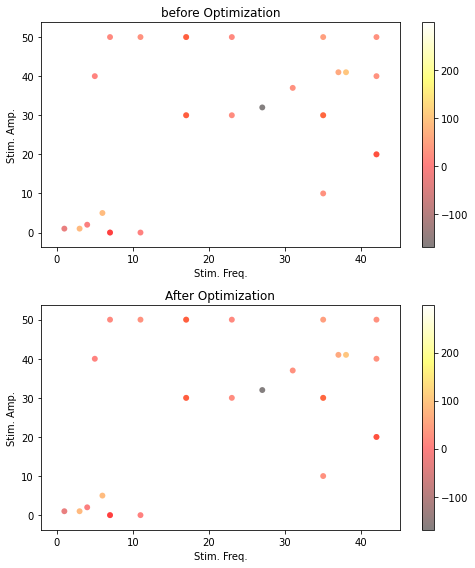

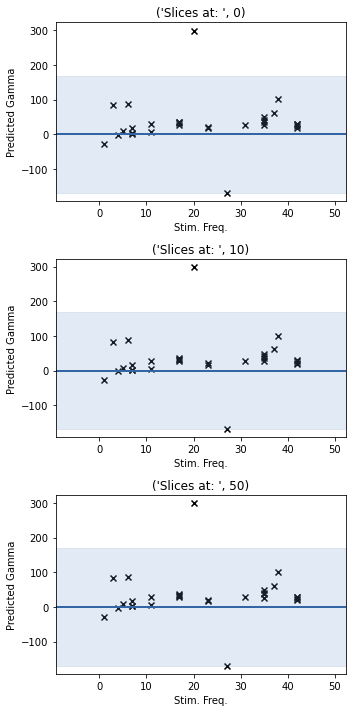

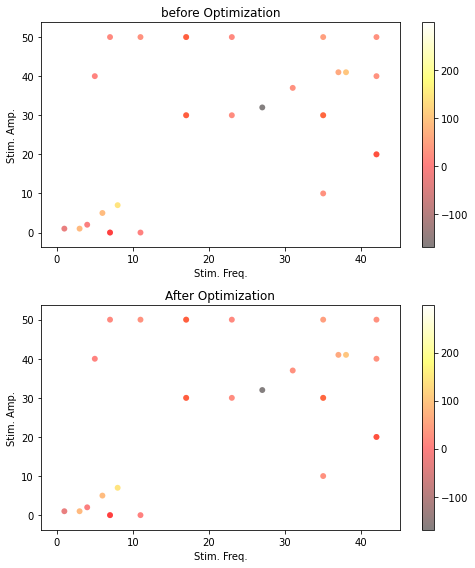

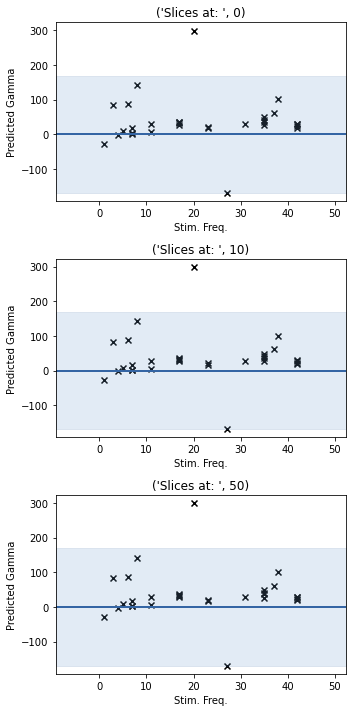

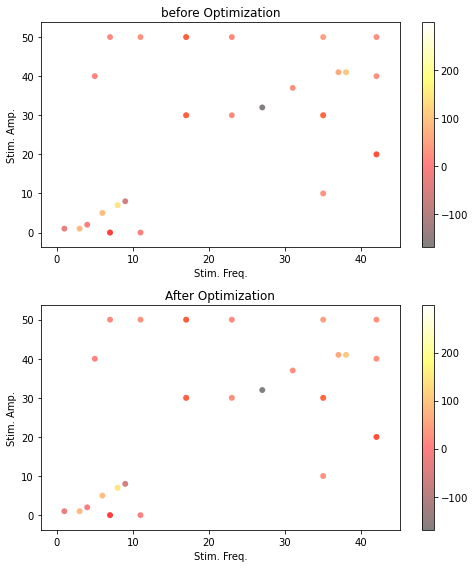

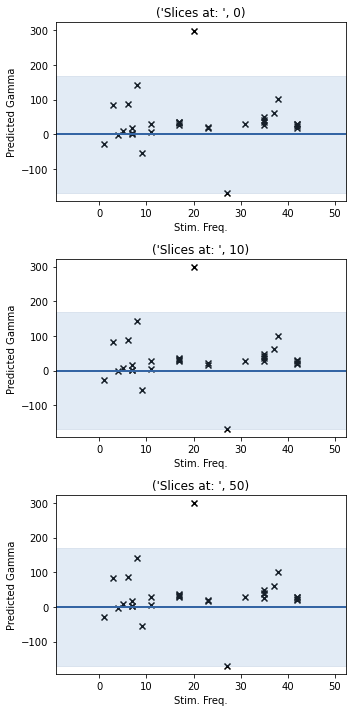

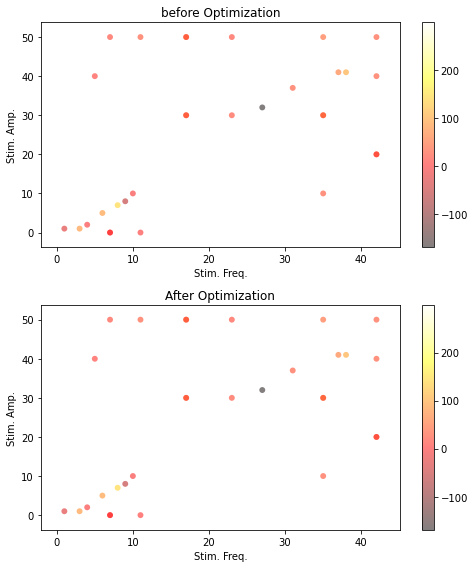

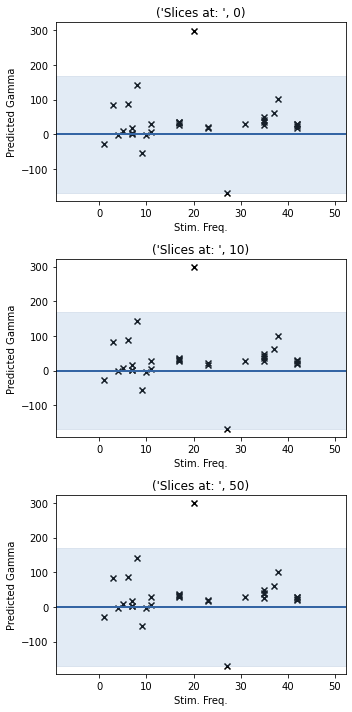

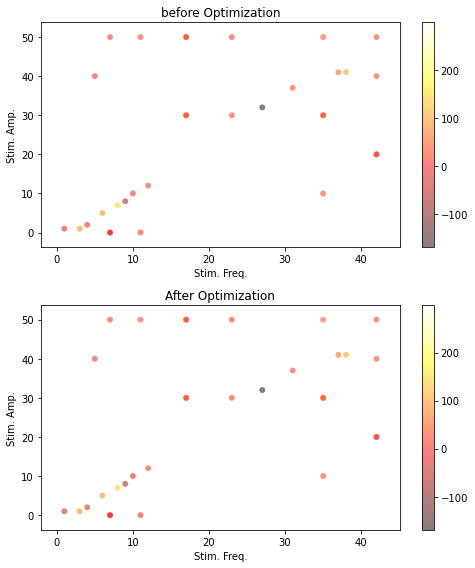

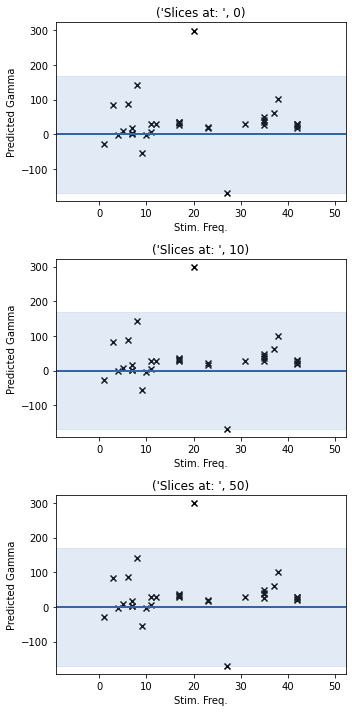

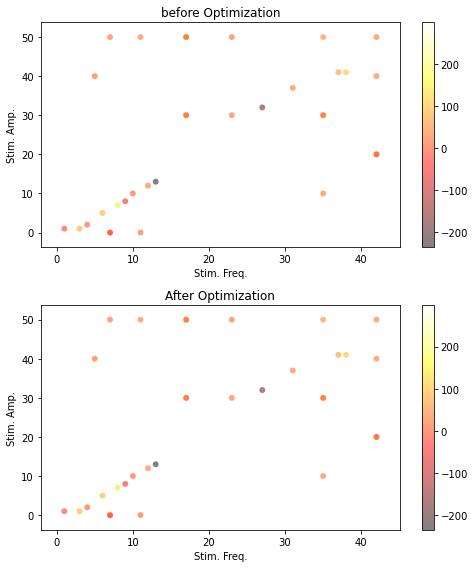

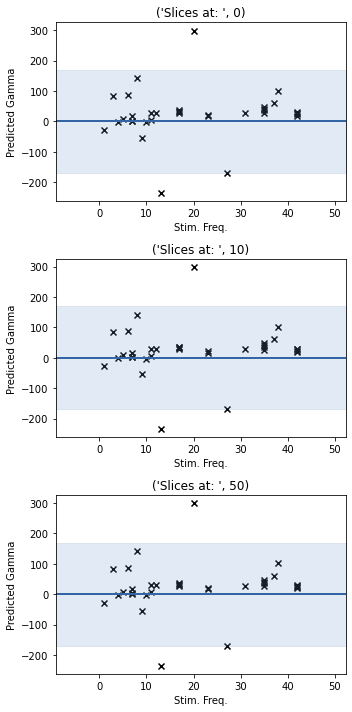

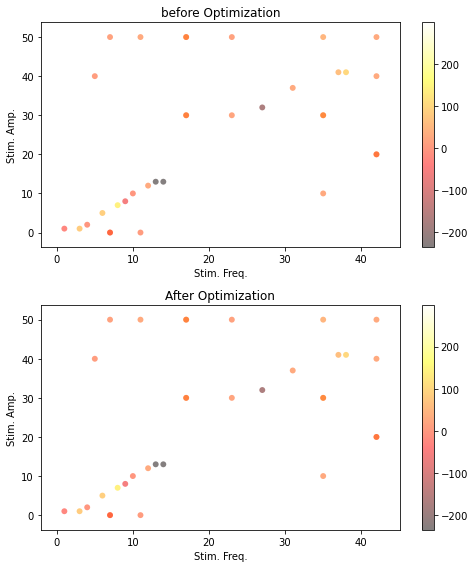

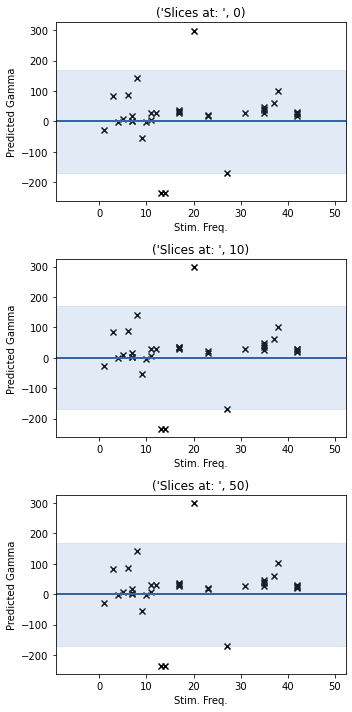

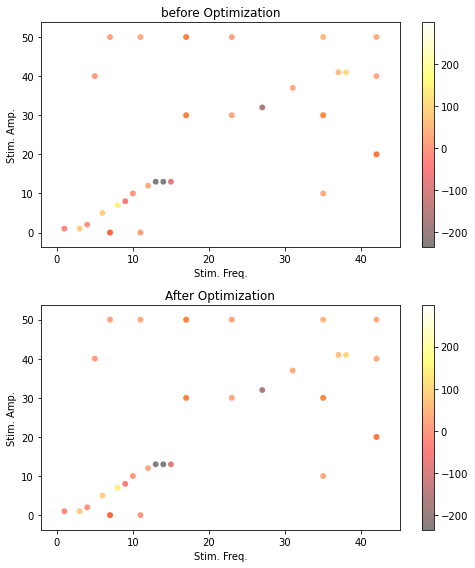

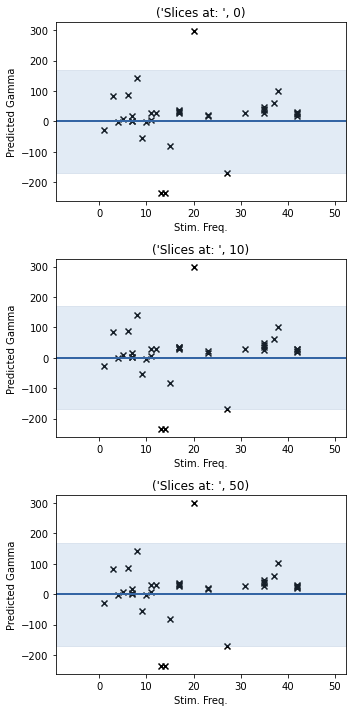

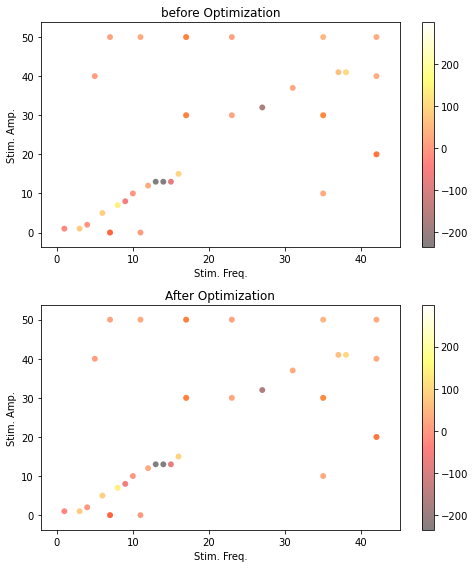

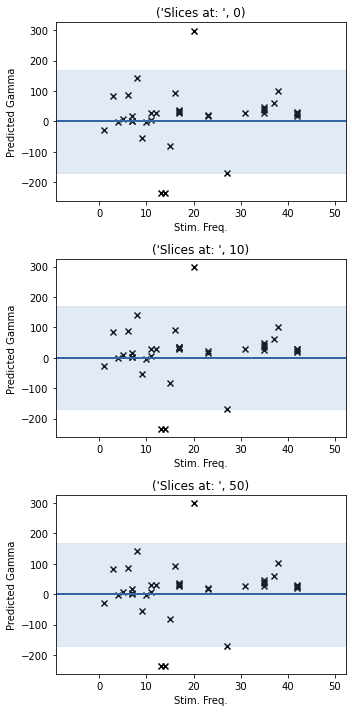

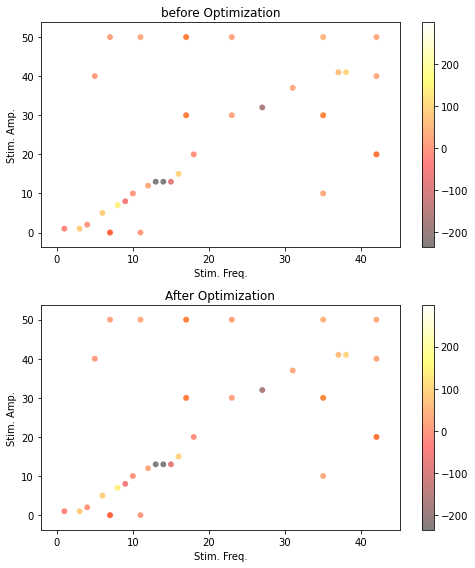

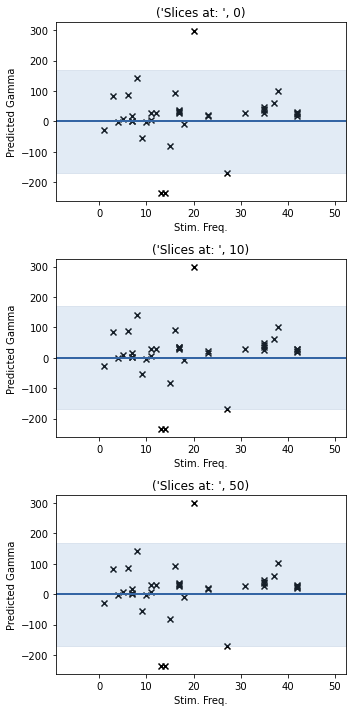

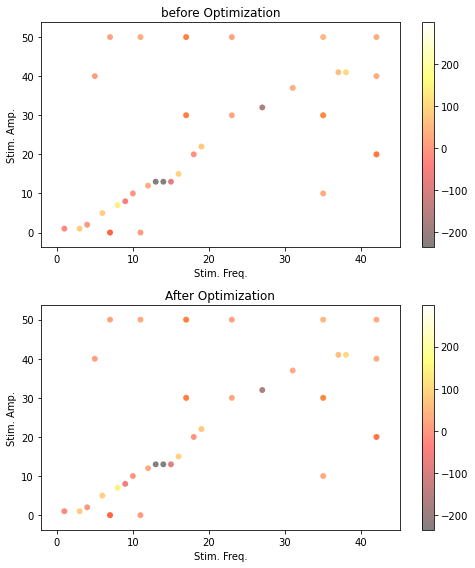

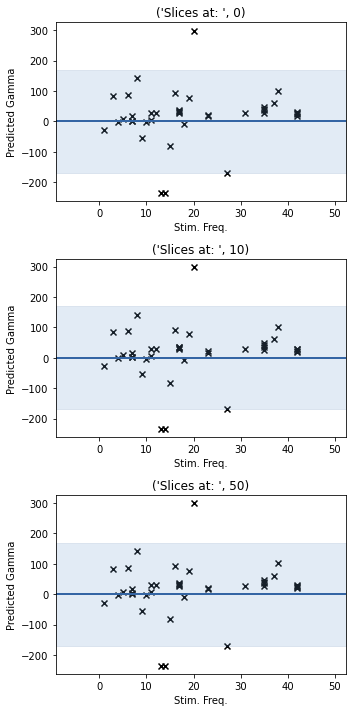

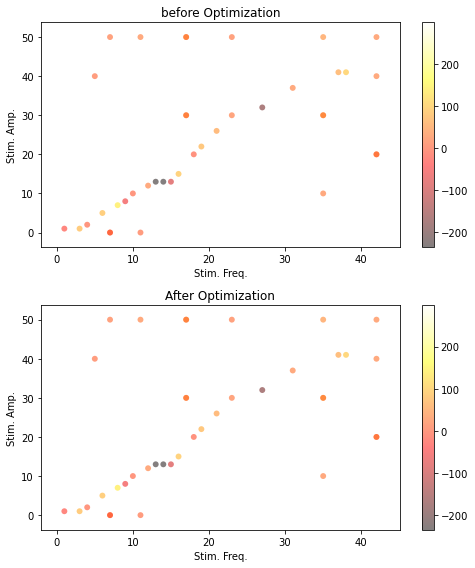

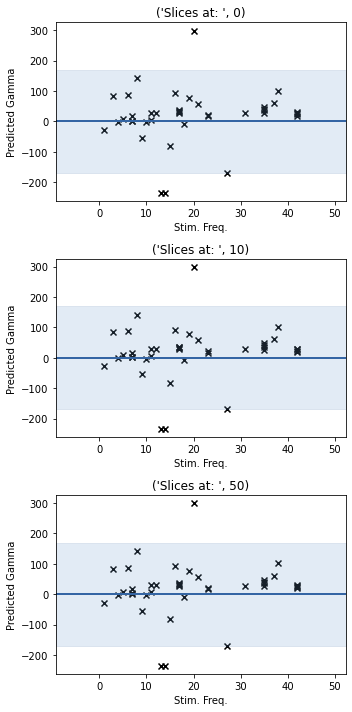

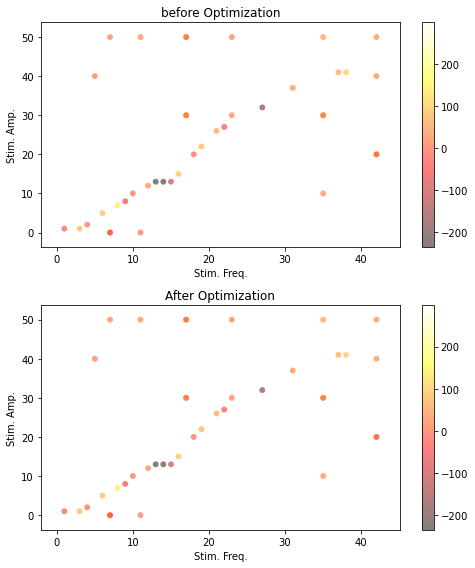

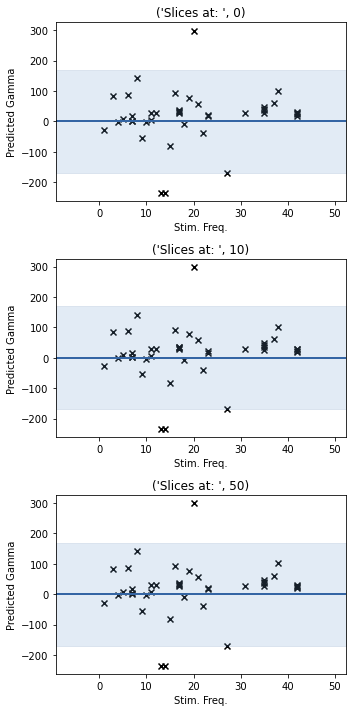

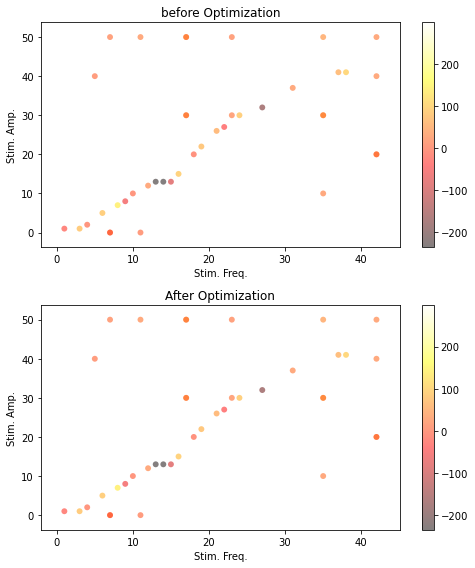

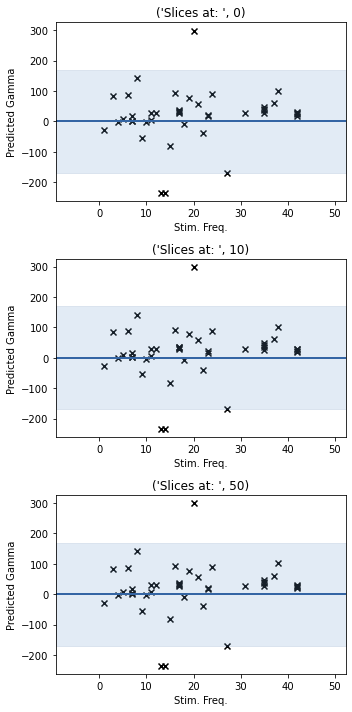

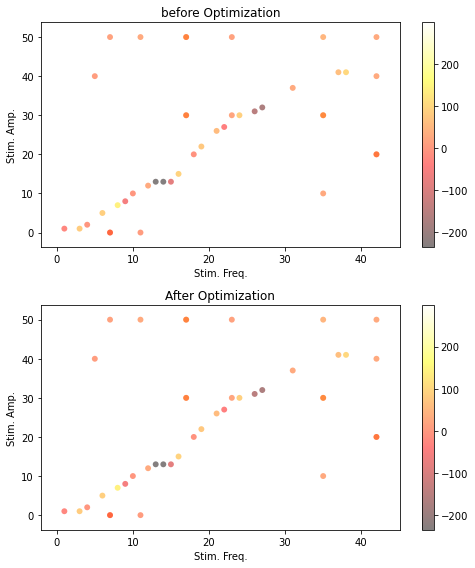

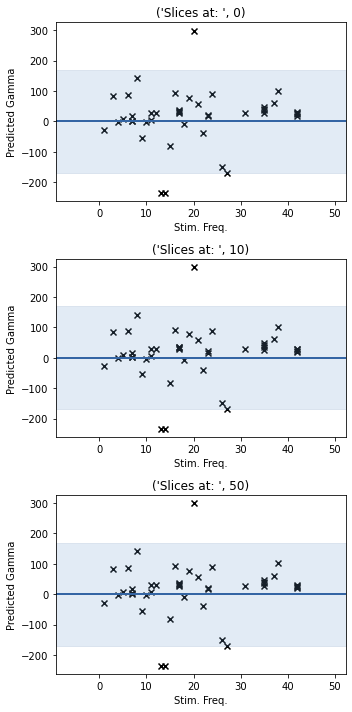

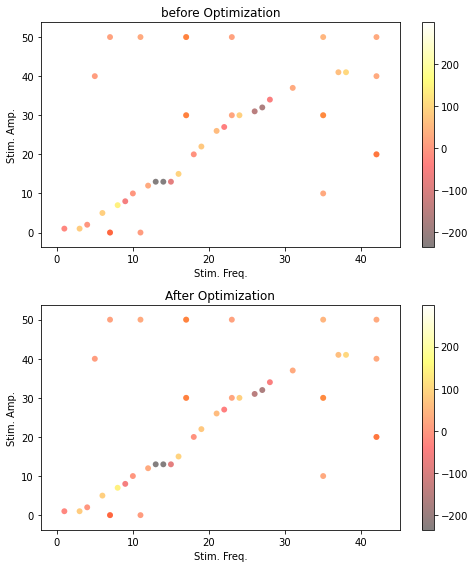

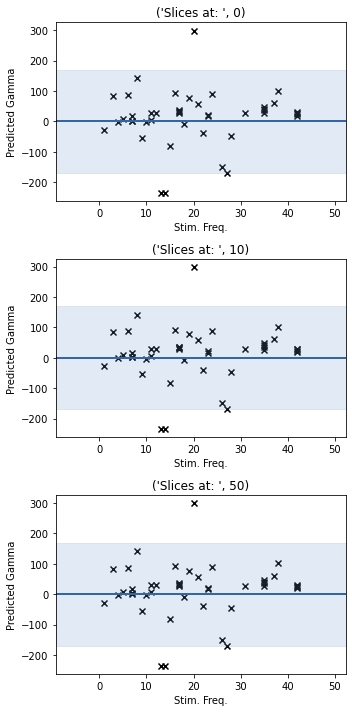

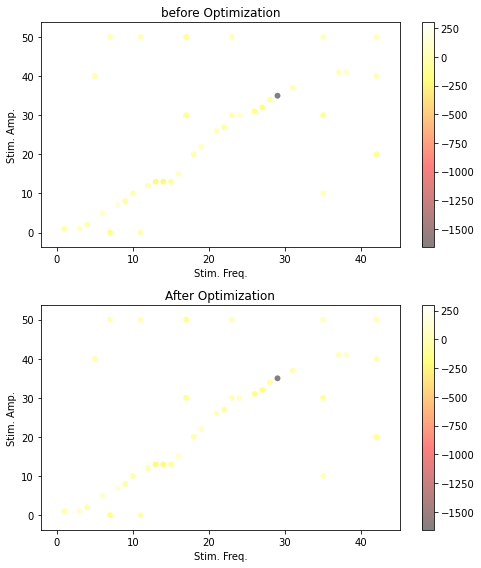

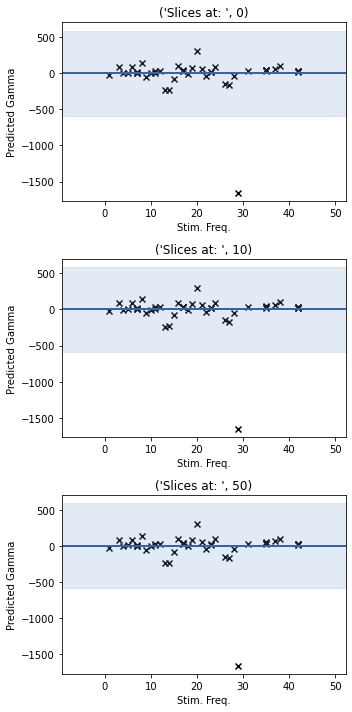

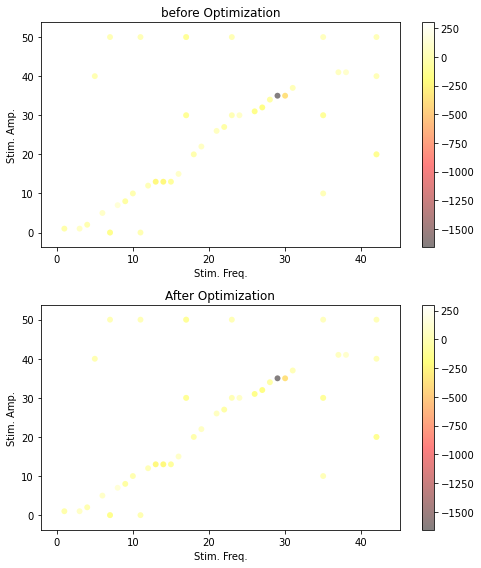

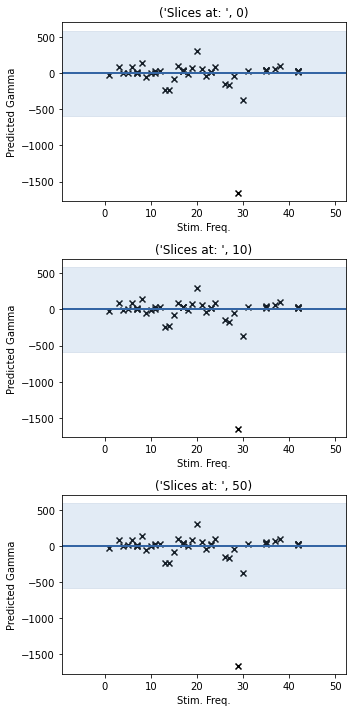

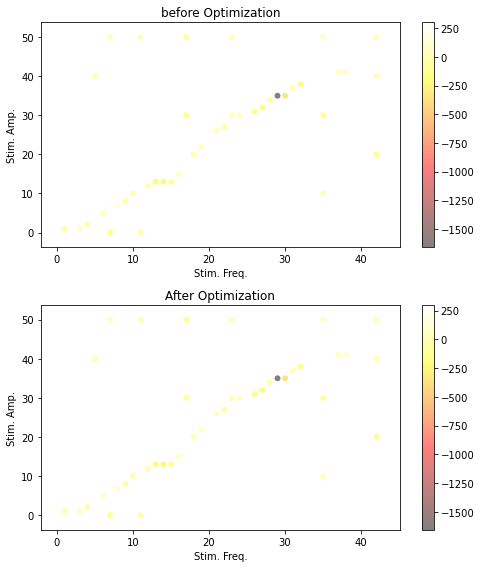

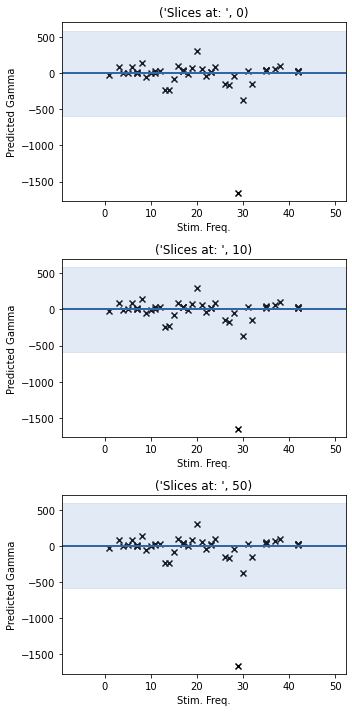

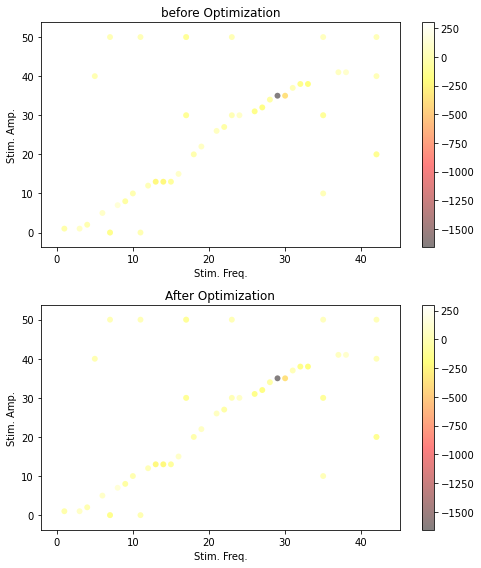

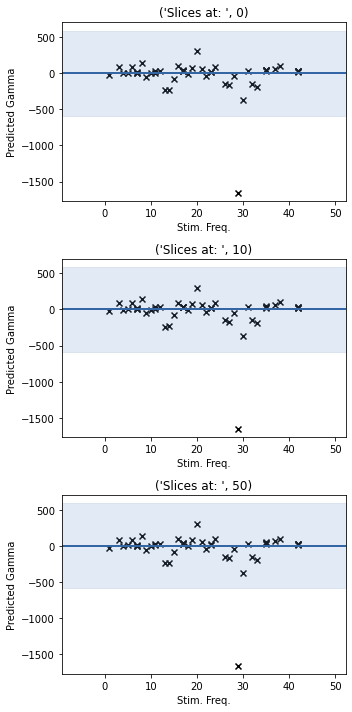

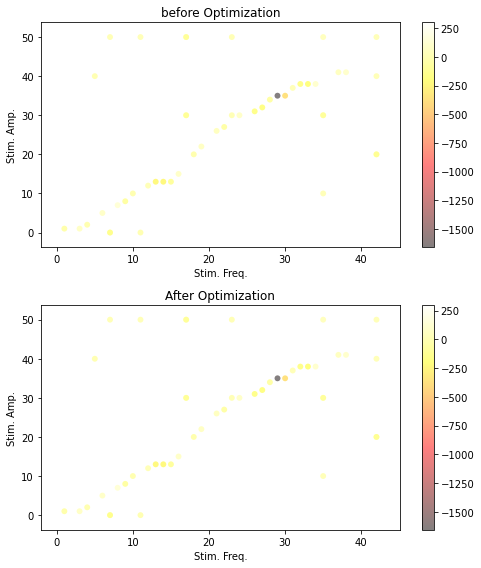

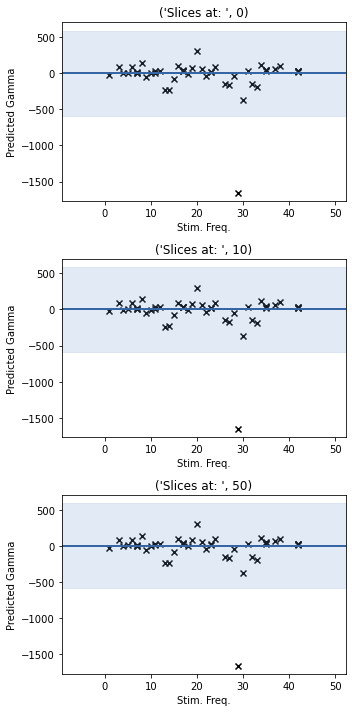

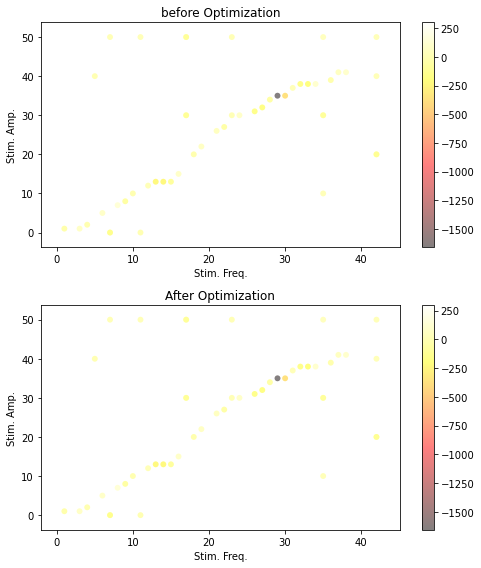

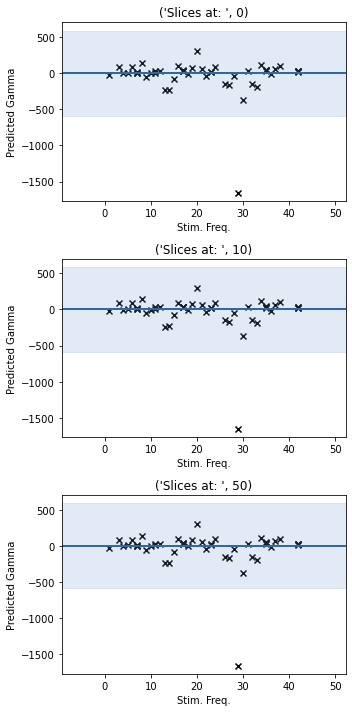

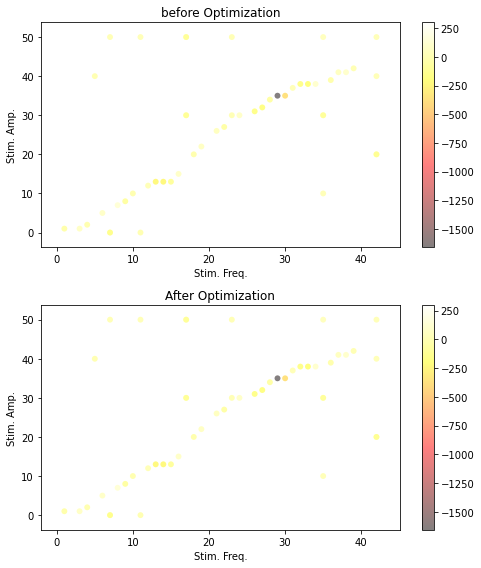

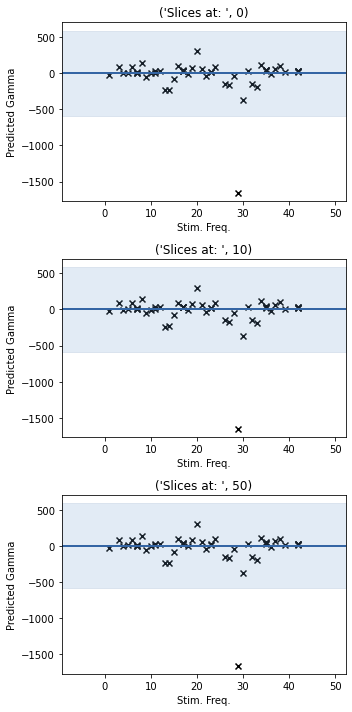

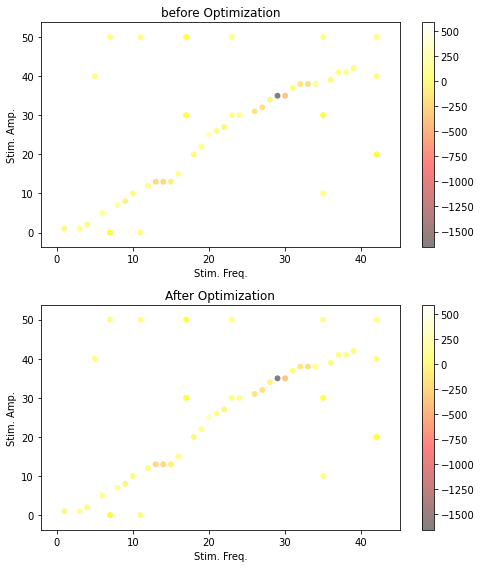

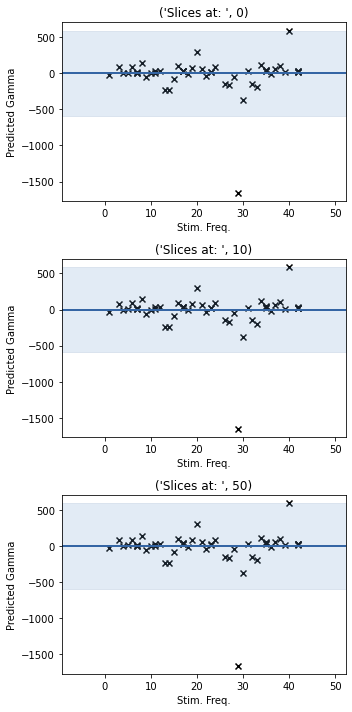

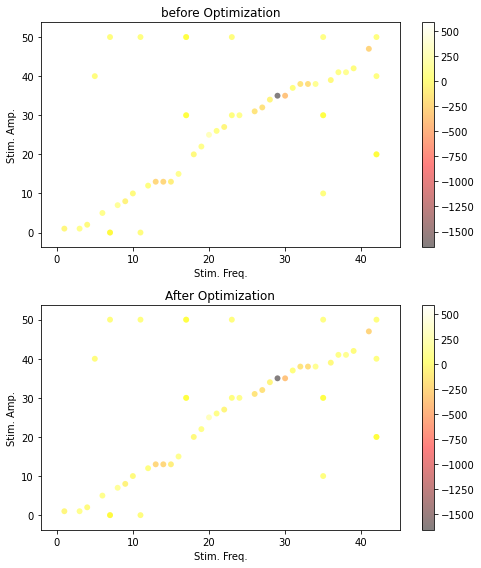

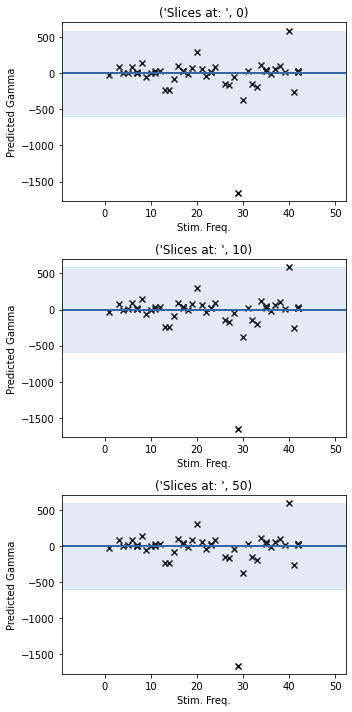

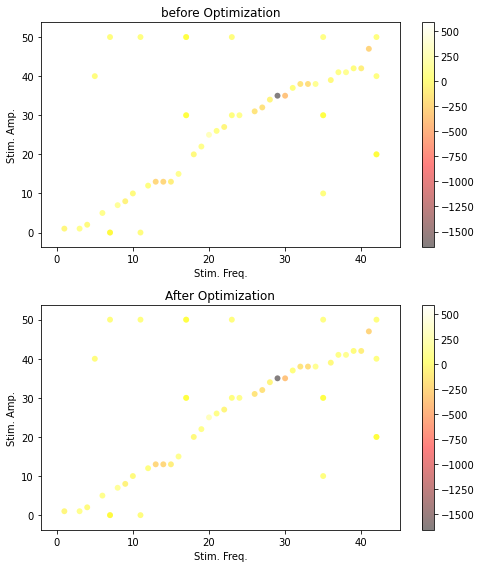

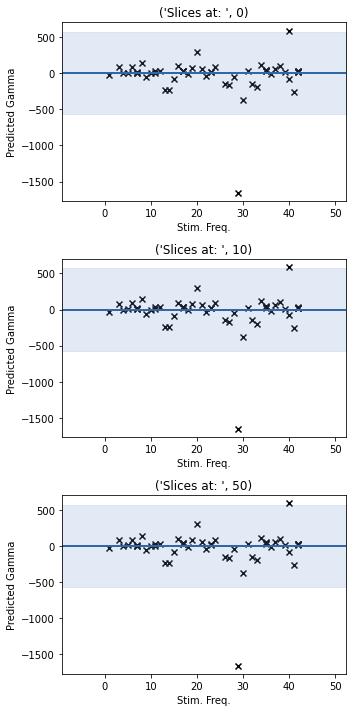

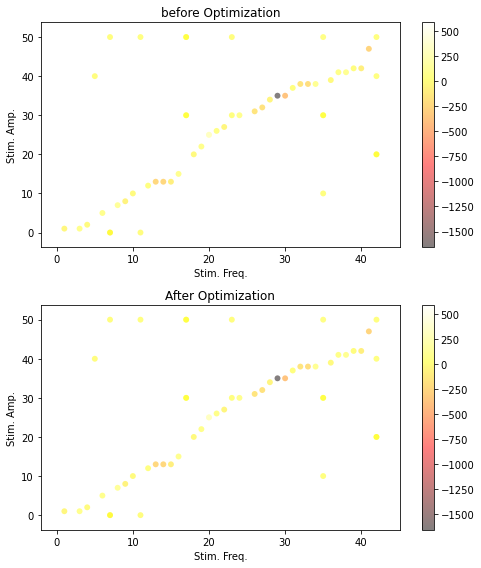

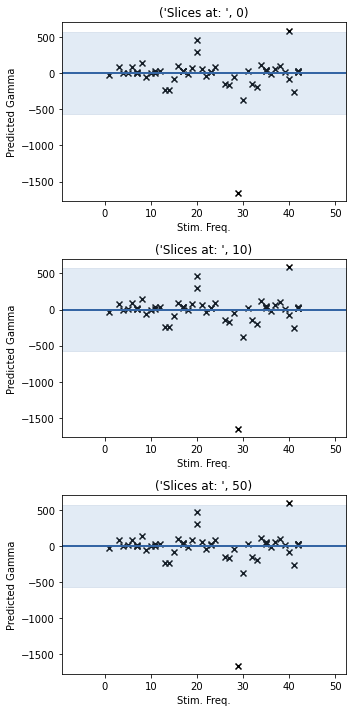

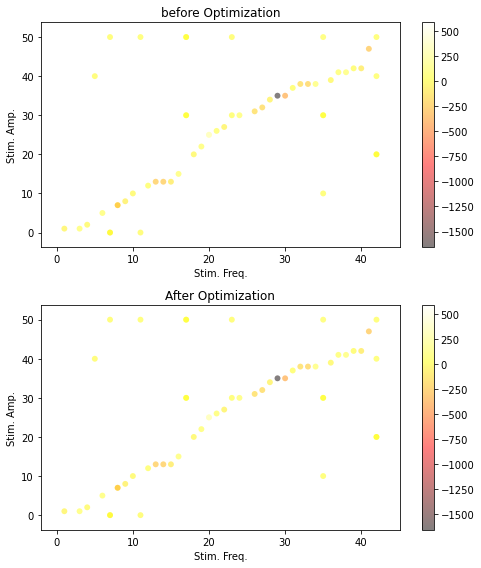

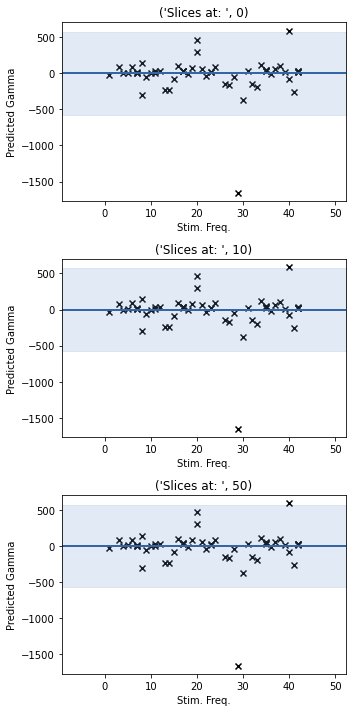

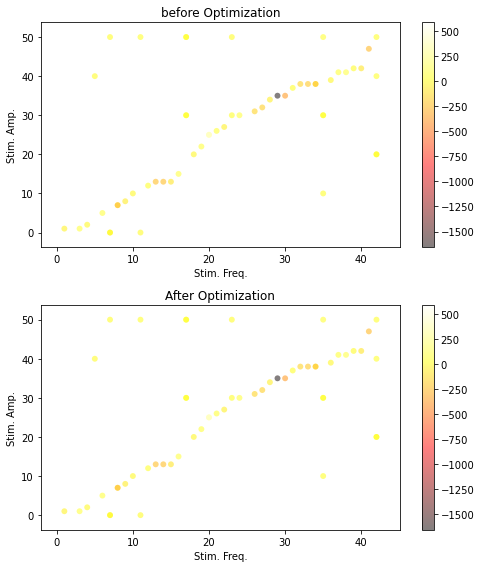

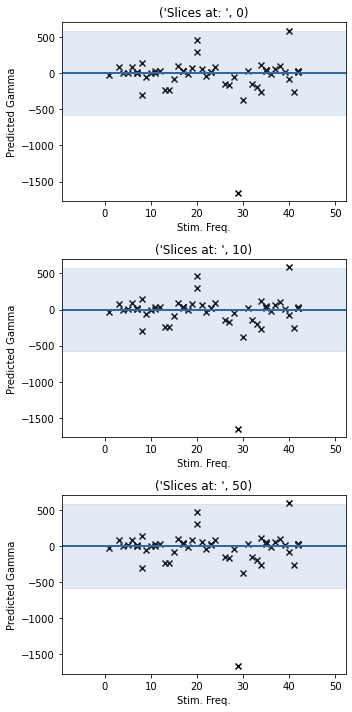

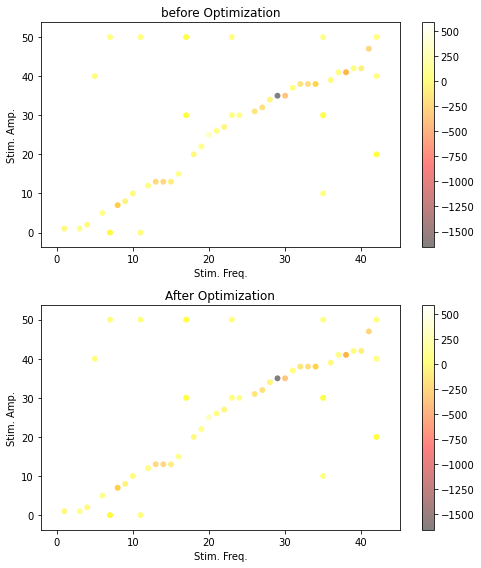

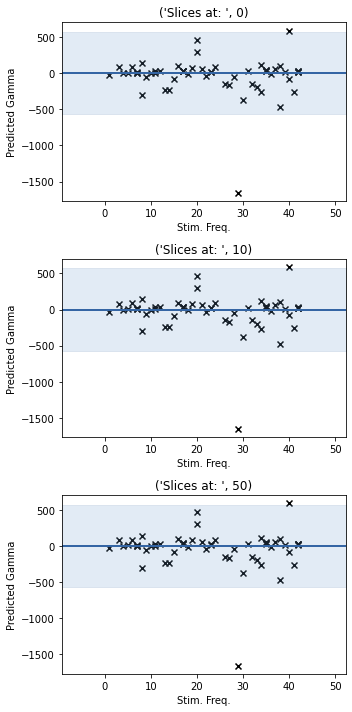

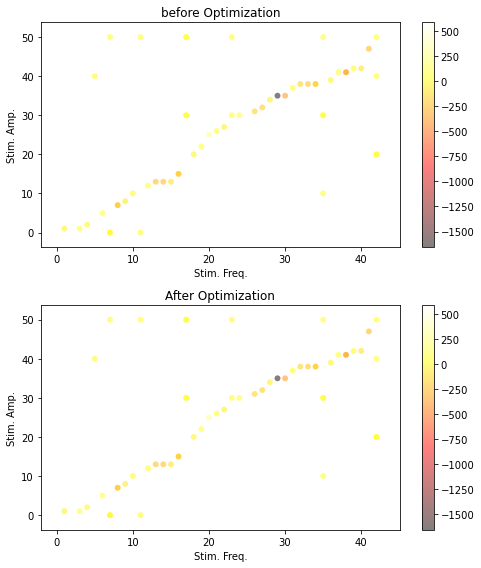

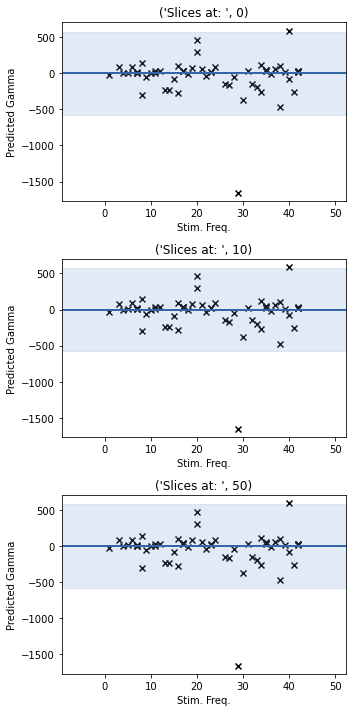

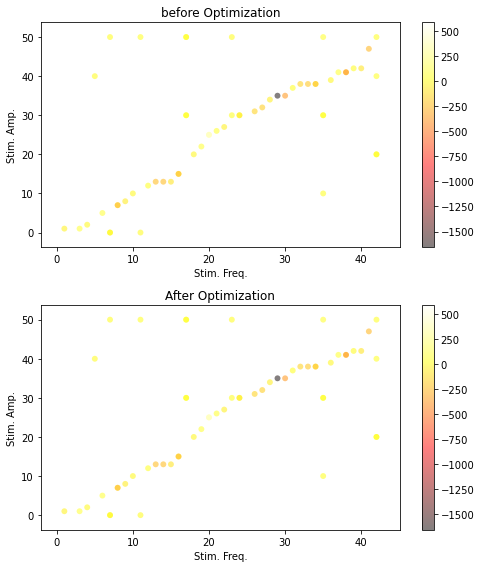

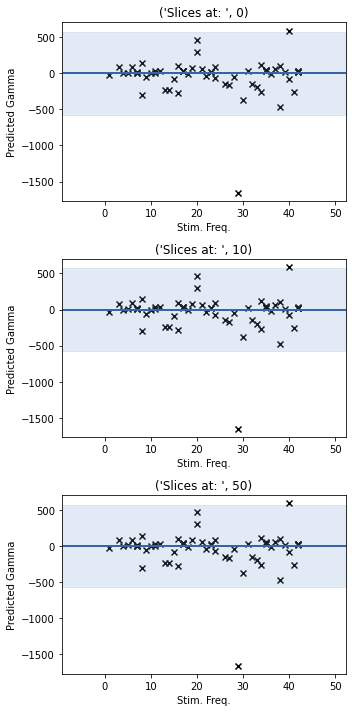

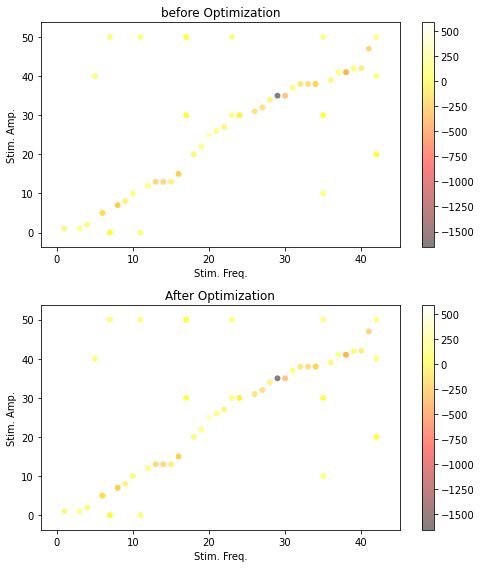

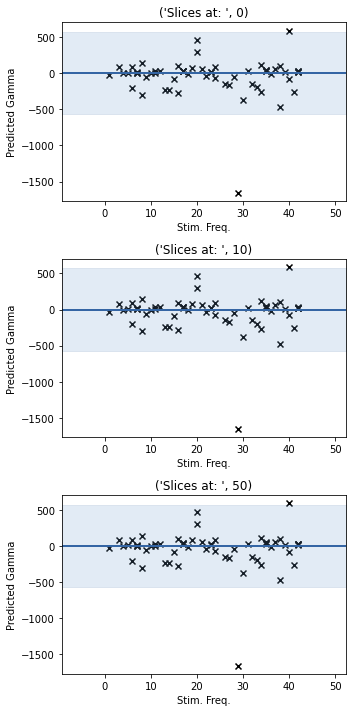

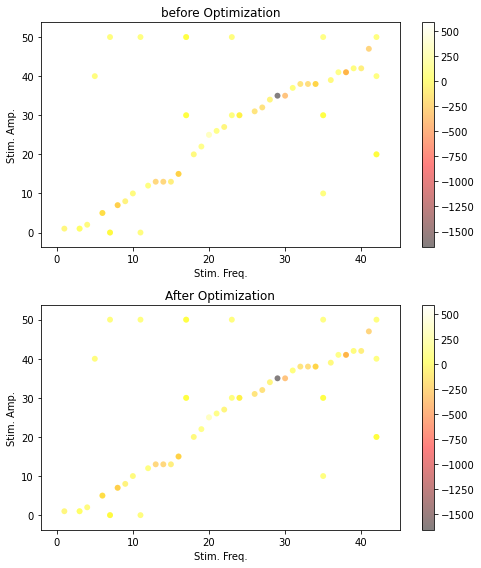

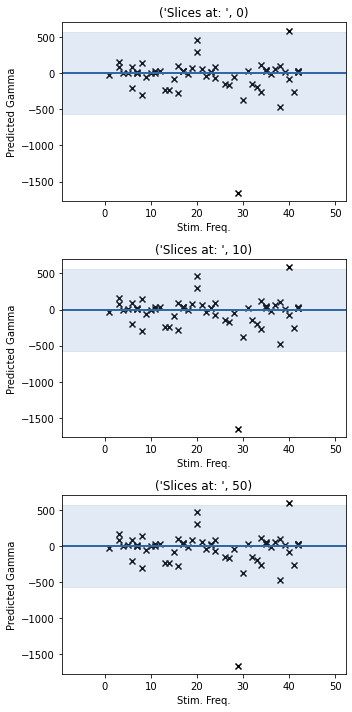

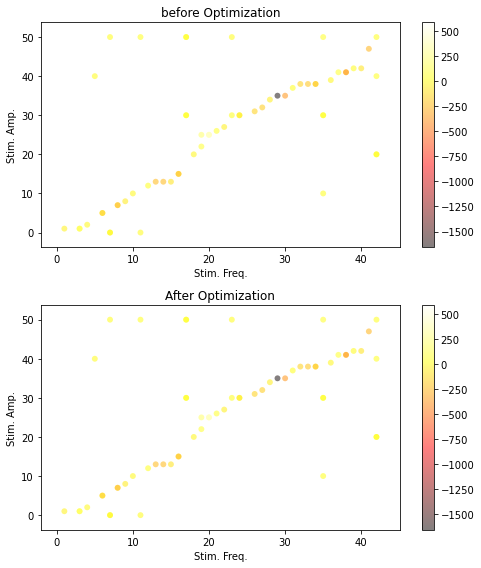

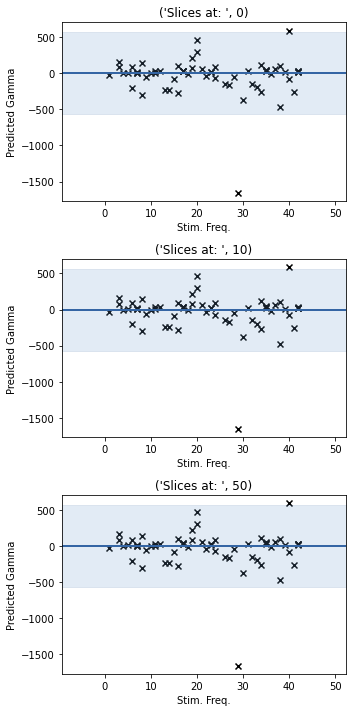

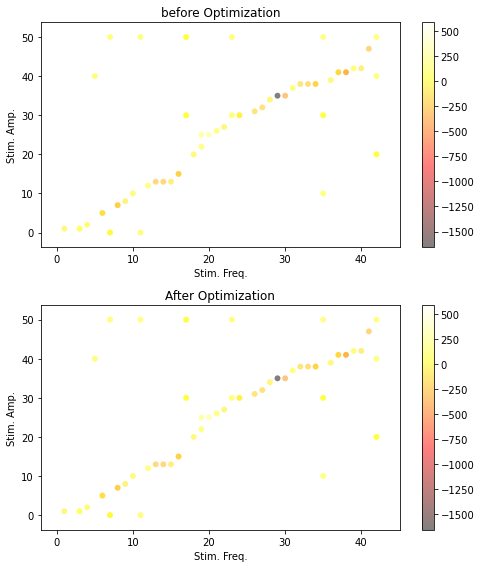

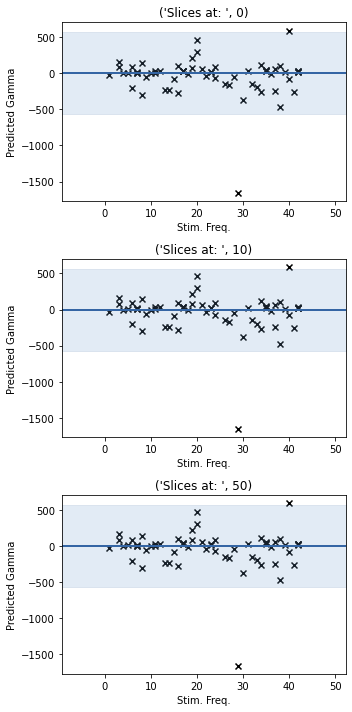

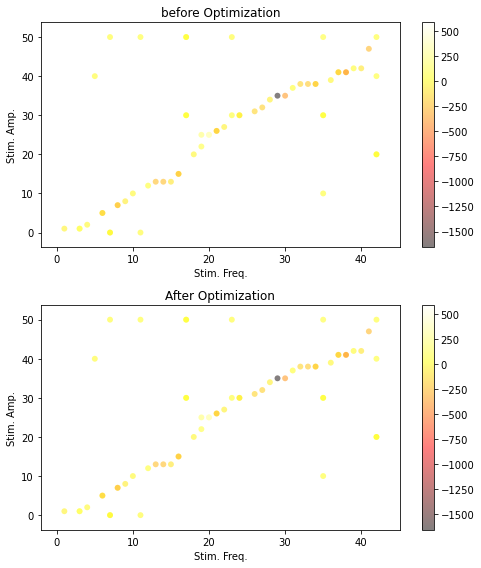

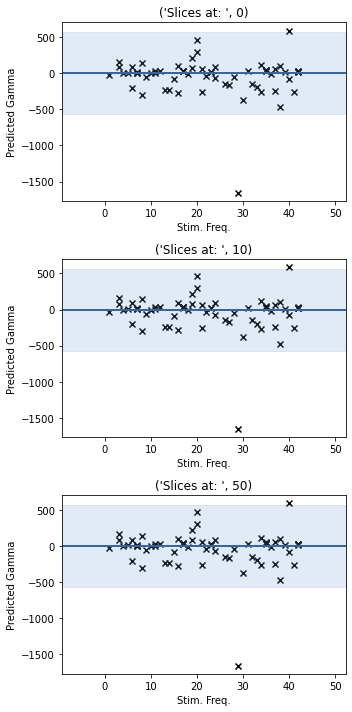

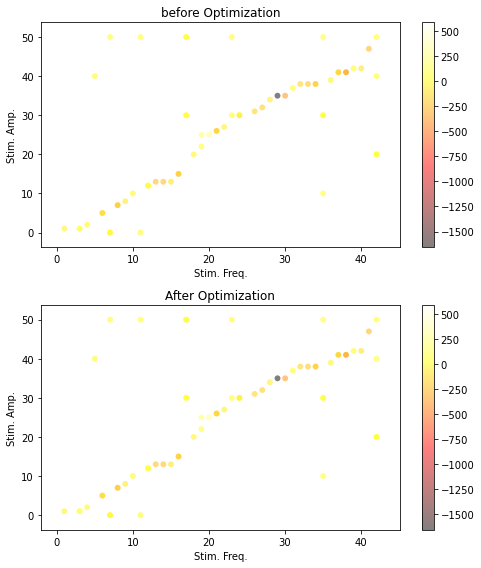

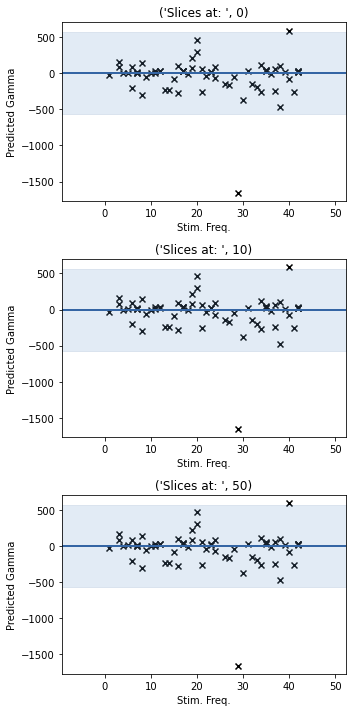

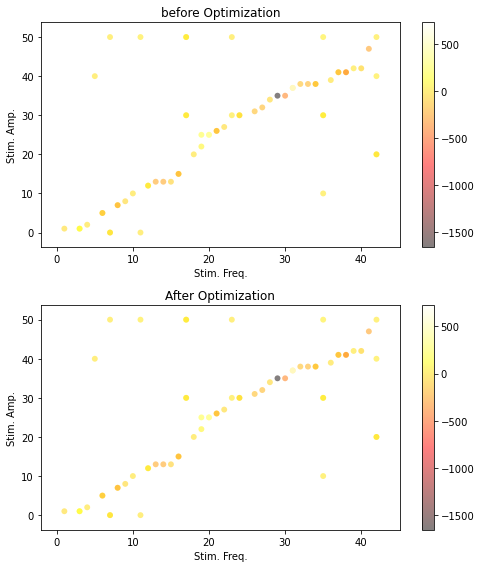

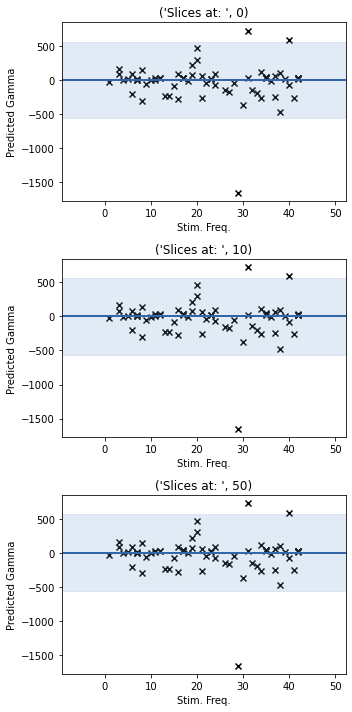

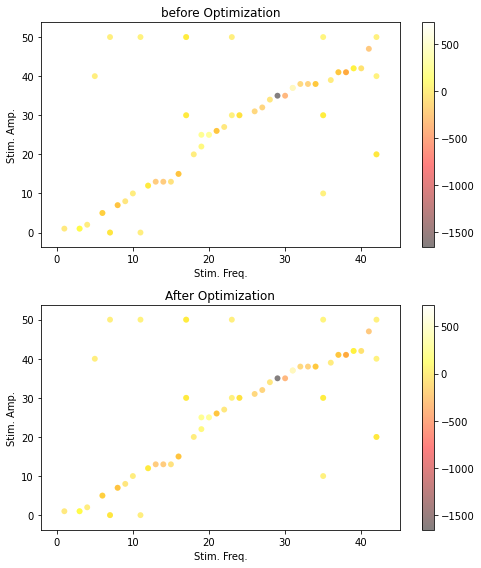

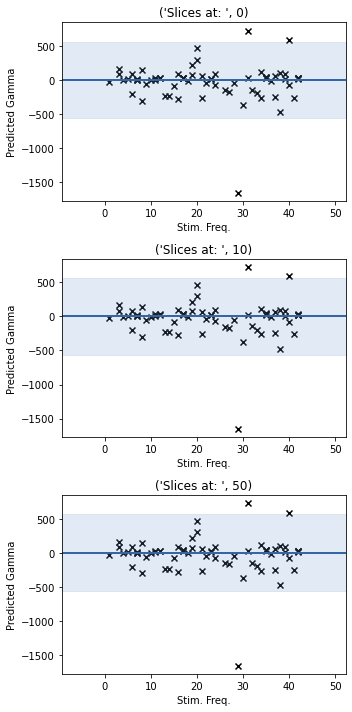

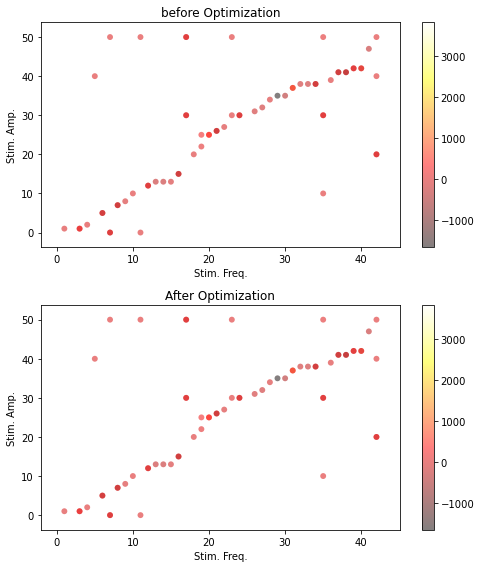

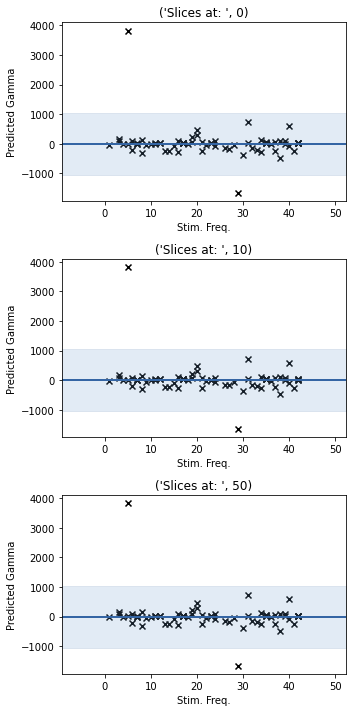

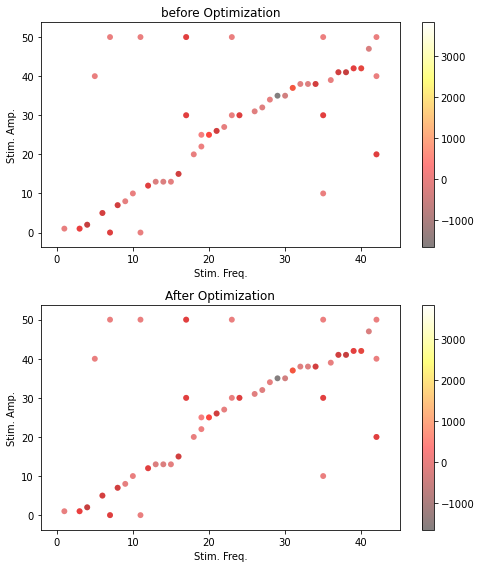

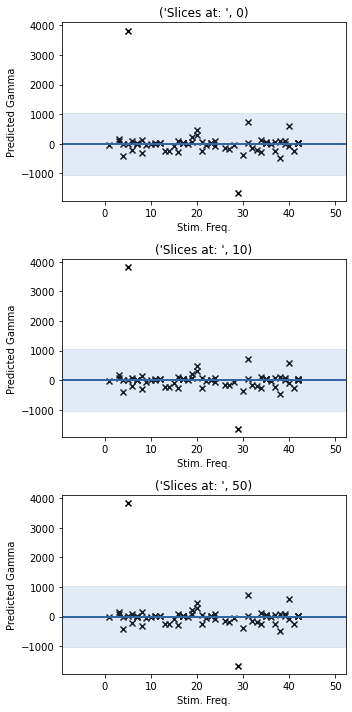

In [31]:
# TODO: set up a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
ucb = np.empty((1, n_samples))
ucb_sample = np.empty((n_acquisition, 3))
postStimGamma_predicted_from_firstModel = np.empty((n_acquisition, 1))
print(np.shape(ucb))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);
    
    ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
    max_ucb = np.max(ucb, axis=0)
    argMax_ucb = ucb.argmax()

    # find the values of argMax_ucb in the sample grid
    ucb_sample[a,:] = testX[argMax_ucb]
    ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,3))
    
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel[a] = trained_model_BaO.posterior_samples(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
    U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

    # sum_preStim_gamma
    next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[mean_preStimGamma[0]]})
    X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel[a]]
    X1_init = np.append(X1_init, next_postStimGamma, axis=0)
    
    trained_model_BaO_AF.add_observer()
    trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    # x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO, slice_dim, ylabel)
    
    

In [37]:
print(ucb_sample)

[[1.02610056e-311 1.02610059e-311 1.02610059e-311]
 [3.70000000e+001 4.10000000e+001 2.17133791e+000]
 [1.00000000e+000 1.00000000e+000 2.17133791e+000]
 [3.80000000e+001 4.10000000e+001 2.17133791e+000]
 [2.70000000e+001 3.20000000e+001 2.17133791e+000]
 [2.00000000e+001 2.50000000e+001 2.17133791e+000]
 [3.00000000e+000 1.00000000e+000 2.17133791e+000]
 [4.00000000e+000 2.00000000e+000 2.17133791e+000]
 [6.00000000e+000 5.00000000e+000 2.17133791e+000]
 [8.00000000e+000 7.00000000e+000 2.17133791e+000]
 [9.00000000e+000 8.00000000e+000 2.17133791e+000]
 [1.00000000e+001 1.00000000e+001 2.17133791e+000]
 [1.20000000e+001 1.20000000e+001 2.17133791e+000]
 [1.30000000e+001 1.30000000e+001 2.17133791e+000]
 [1.40000000e+001 1.30000000e+001 2.17133791e+000]
 [1.50000000e+001 1.30000000e+001 2.17133791e+000]
 [1.60000000e+001 1.50000000e+001 2.17133791e+000]
 [1.80000000e+001 2.00000000e+001 2.17133791e+000]
 [1.90000000e+001 2.20000000e+001 2.17133791e+000]
 [2.10000000e+001 2.60000000e+0

In [38]:
print(postStimGamma_predicted_from_firstModel)

[[ 3.33255131e+01]
 [ 6.13200335e+01]
 [-2.73686082e+01]
 [ 1.01109262e+02]
 [-1.68901399e+02]
 [ 2.99117529e+02]
 [ 8.36837471e+01]
 [-1.67784139e+00]
 [ 8.73013547e+01]
 [ 1.42130132e+02]
 [-5.48035347e+01]
 [-3.05505172e+00]
 [ 2.88358412e+01]
 [-2.35222223e+02]
 [-2.35158531e+02]
 [-8.22151250e+01]
 [ 9.27425304e+01]
 [-8.27665001e+00]
 [ 7.71131100e+01]
 [ 5.80297497e+01]
 [-3.91524074e+01]
 [ 8.86881884e+01]
 [-1.49303547e+02]
 [-4.64441301e+01]
 [-1.65696214e+03]
 [-3.73181716e+02]
 [-1.47067260e+02]
 [-1.92843281e+02]
 [ 1.13657887e+02]
 [-1.49744363e+01]
 [ 1.01581250e+01]
 [ 5.90504261e+02]
 [-2.58319869e+02]
 [-7.79749394e+01]
 [ 4.65392666e+02]
 [-3.03191047e+02]
 [-2.64466205e+02]
 [-4.73314405e+02]
 [-2.79407644e+02]
 [-6.86047592e+01]
 [-2.02723374e+02]
 [ 1.60970217e+02]
 [ 2.14443005e+02]
 [-2.45956457e+02]
 [-2.59360265e+02]
 [ 2.76957913e+01]
 [ 7.27296727e+02]
 [ 8.50396668e+01]
 [ 3.82505675e+03]
 [-4.03107782e+02]]


Text(0, 0.5, 'postStim Gamma')

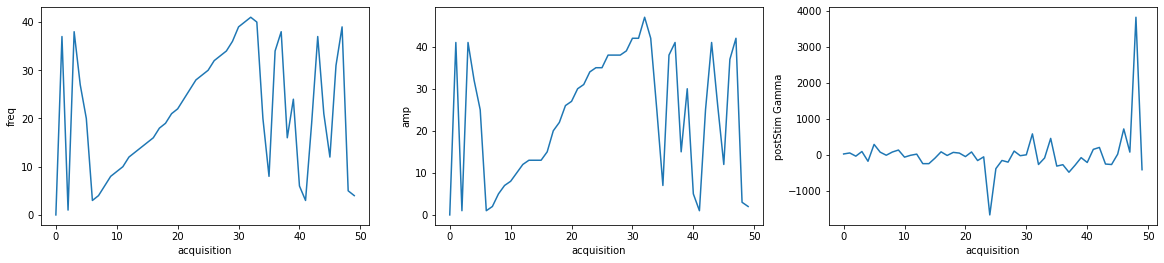

In [52]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,50), ucb_sample[:,0:1], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")

plt.subplot(1,3,2)
plt.plot(np.arange(0,50), ucb_sample[:,1:2], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")

plt.subplot(1,3,3)
plt.plot(np.arange(0,50), postStimGamma_predicted_from_firstModel, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")

In [55]:
# From sample #20next_idx_to_optimize, pick 20 samples in U1, X0 and X1 such that the freq = 42
next_idx_to_optimize = []

for idx in range(n_samples, np.shape(U1)[0]):
    if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
        # print(idx)
        next_idx_to_optimize.append(idx)
        if np.size(next_idx_to_optimize)>1:
            break
        
print(next_idx_to_optimize)

[163, 164]


In [56]:
U1_next = U1.loc[next_idx_to_optimize,:]
X0_psd_next = X0_psd.loc[next_idx_to_optimize]
X1_next = X1[next_idx_to_optimize,:]
print('Sum preStim gamma are: \n', X0_psd_next, '\n','freq and amplitude used are: \n', U1_next)
print('sum postStim gamma are: \n', X1_next, '\n', np.shape(X1_next))

Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952
164           0.821572 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
164      42      10
sum postStim gamma are: 
 [[17.37915242]
 [ 7.48766022]] 
 (2, 1)


#### Plot before and after optimization 

In [57]:
# Combine initial samples with next samples
U1_combo = pd.concat([U1_init,U1_next])
X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
X1_combo = np.append(X1_init, X1_next, axis=0)

print(np.shape(X1_combo))
print(U1_combo, '\n', X0_psd_combo.head(), '\n', X1_combo[0:4])

(22, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17      50
18        7       0
19       42      20
163      42      40
164      42      10 
    sum_preStim_gamma
0           3.266571
1           2.425945
2           3.117866
3           2.868627
4           3.521665 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]]


In [58]:
U1_combo.reset_index()
U1_combo=U1_combo[['Stim_1', 'Stim_2']]
U1_combo.head()

X0_psd_combo.reset_index()
X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
X0_psd_combo.head()


sum_preStim_gamma
0           3.266571
1           2.425945
2           3.117866
3           2.868627
4           3.521665

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e5a723d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a9e5763940>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0005   7.962524e+01   3.496965e-02 
    00s05  0008   7.935234e+01   6.689312e-05 
    00s07  0010   7.935193e+01   4.166894e-05 
    00s19  0025   7.935079e+01   7.182260e-06 
    00s22  0030   7.935058e+01   1.939578e-10 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e544f730>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a9e5b013d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e5a01e50>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2a9e5c292e0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2a9e5c29310>]}

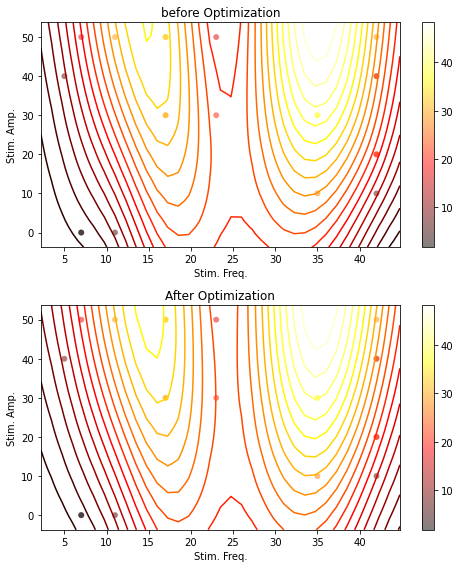

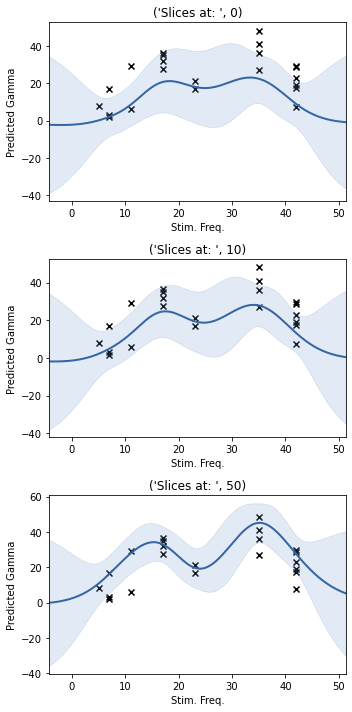

In [59]:
x_BaO, y_BaO, trained_model_BaO =model.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Acquisition Function pseudo code and draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end